# Song Emotion Regression: Complete Pipeline  
**Authors:** Your Name  
**Date:** YYYY‐MM‐DD  


## 0️⃣ Installs  
“Make sure to run this cell first in a **fresh environment** (e.g. Colab or local Anaconda) so that all dependencies are satisfied.”


In [1]:
# 📌 שלב 1: עדכון pip וכלי ההתקנה
!pip install --upgrade pip setuptools wheel

# 📌 שלב 2: התקנת ספריות למידת מכונה ו-NLP
!pip install --upgrade transformers torch torchvision torchaudio scikit-learn pandas matplotlib seaborn openai ipywidgets tqdm

# 📌 שלב 3: התקנת חבילה להאצת אימון
!pip install "accelerate>=1.7.0"

# 📌 שלב 4: התקנת חבילה לקריאה וכתיבה של קבצי Excel
!pip install openpyxl

# 📌 שלב 5: התקנת חבילות Azure ו-OpenAI לשימוש ב-Grok
!pip install --upgrade azure-core azure-identity openai

  Using cached azure_core-1.34.0-py3-none-any.whl.metadata (42 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [azure-identity]


In [2]:
!python --version

Python 3.11.12


## 1️⃣ Imports  


In [3]:
import os
import ast
import time
import json
import re
from datetime import timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split, KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error

from transformers import (
    BertTokenizer, BertConfig, BertPreTrainedModel, BertModel,
    RobertaTokenizer, RobertaConfig, RobertaPreTrainedModel, RobertaModel,
    TrainingArguments, Trainer
)

# Azure OpenAI client (for zero-shot “Grok”)
from openai import AzureOpenAI
from azure.core.credentials import AzureKeyCredential

from tqdm.notebook import tqdm
from IPython.display import display


## 2️⃣ Device Setup  
Check if a GPU is available and configure PyTorch accordingly.


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## 3️⃣ EDA / Exploratory Data Analysis  
Load the dataset, inspect its shape, print a few rows, visualize emotion distributions, and look at correlations.


Raw DataFrame shape: (500, 12)


,track_id,track_name,playlist_genre,lyrics,artist_name,spotify_url,Joy,Sadness,Anger,Fear,Surprise,Tenderness
0,6hmhG1b4LEyNuashVvuIAo,never forget you,Pop,"['i', 'used', 'to', 'be', 'so', 'happy', 'but'...",Zara Larsson,https://open.spotify.com/track/6hmhG1b4LEyNuas...,1.1665,1.000,0.8335,0.6665,0.5000,1.1670
1,4QIo4oxwzzafcBWkKjDpXY,xanny,R&b,"['what', 'is', 'it', 'about', 'them?', '', 'i'...",Billie Eilish,https://open.spotify.com/track/4QIo4oxwzzafcBW...,0.5000,1.000,0.6670,0.6670,0.5000,1.1670
2,1D1nixOVWOxvNfWi0UD7VX,unwritten,Pop,"['i', 'am', 'unwritten', '', ""can't"", 'read', ...",Natasha Bedingfield,https://open.spotify.com/track/1D1nixOVWOxvNfW...,1.1670,1.000,0.5000,0.5000,1.1665,1.3335
3,4jvjzW7Hm0yK4LvvE0Paz9,falling down - bonus track,Rap,"['come,', ""let's"", 'watch', 'the', 'rain', 'as...",Lil Peep,https://open.spotify.com/track/4jvjzW7Hm0yK4Lv...,0.6670,1.000,0.6665,0.5000,0.0000,1.0000
4,6jreFSOTUAViWjKyzOC4Kg,remedy,Pop,"['i', ""didn't"", 'know', 'that', 'i', 'was', 'b...",Alesso,https://open.spotify.com/track/6jreFSOTUAViWjK...,1.1665,0.833,0.3330,0.3330,1.3335,1.3335



Missing values per column:
track_id          0
track_name        0
playlist_genre    0
lyrics            0
artist_name       0
spotify_url       0
Joy               0
Sadness           0
Anger             0
Fear              0
Surprise          0
Tenderness        0
dtype: int64

After cleaning, DataFrame shape: (497, 13)


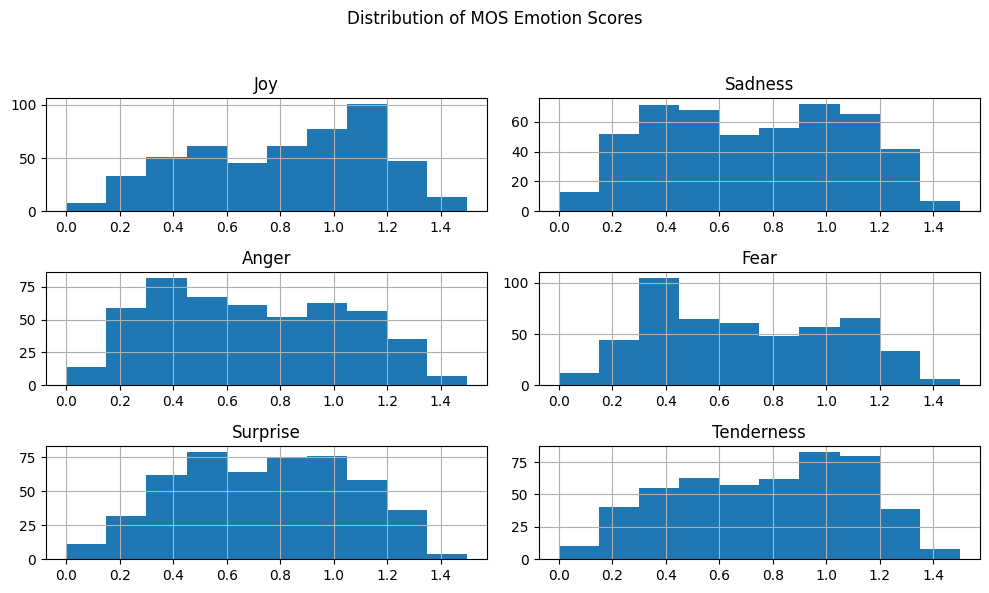

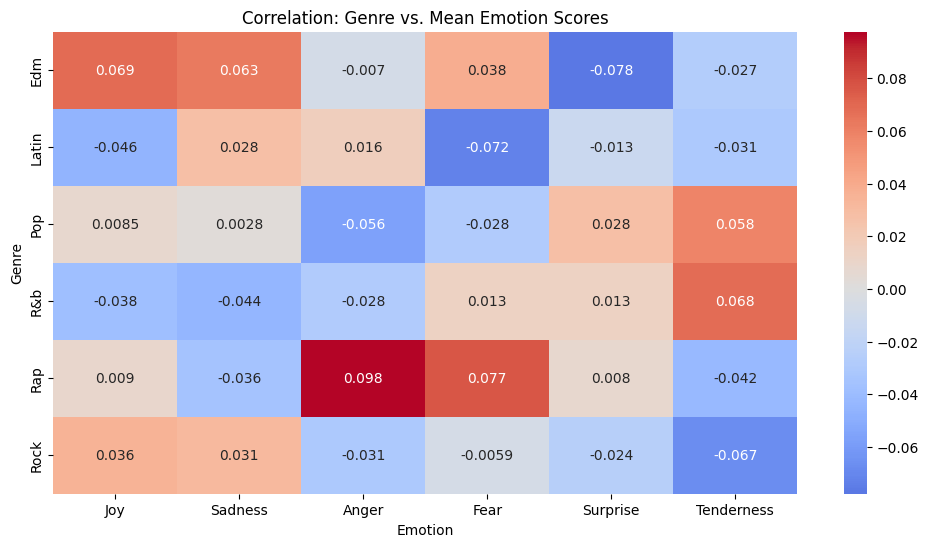

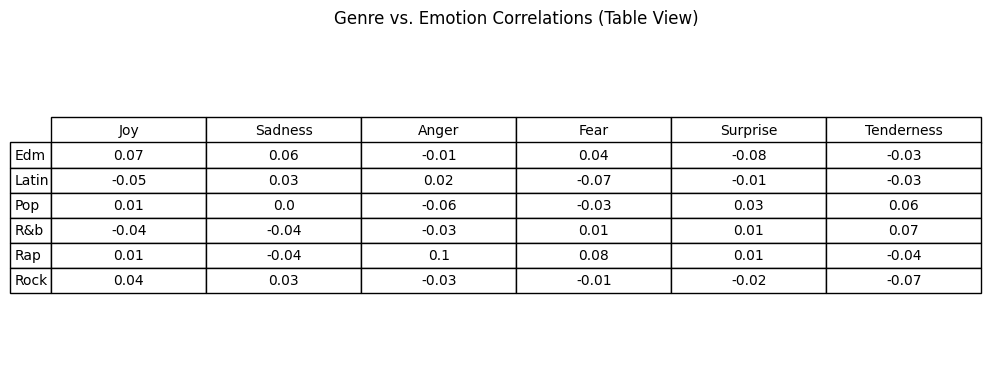

In [5]:
# 3.1 Load raw Excel (sheet "Results")
df = pd.read_excel("500 song tagging.xlsx", sheet_name="Results")

# 3.2 Drop unnamed (empty) columns
df = df.loc[:, ~df.columns.str.startswith("Unnamed")]

# 3.3 Preview
print("Raw DataFrame shape:", df.shape)
display(df.head(5))

# 3.4 Check for missing
print("\nMissing values per column:")
print(df.isna().sum())

# 3.5 For EDA, drop any songs missing lyrics or any emotion label
df = df.dropna(subset=["track_name","playlist_genre","artist_name","lyrics",
                       "Joy","Sadness","Anger","Fear","Surprise","Tenderness"])

# 3.6 Convert the “lyrics” column if pre‐tokenized lists
def clean_lyrics(cell):
    if isinstance(cell, str) and cell.startswith("["):
        try:
            tokens = ast.literal_eval(cell)
            if isinstance(tokens, list):
                return " ".join(tokens)
        except:
            return None
    return str(cell).strip()

df["lyrics_clean"] = df["lyrics"].apply(clean_lyrics)
df = df.dropna(subset=["lyrics_clean"])

print("\nAfter cleaning, DataFrame shape:", df.shape)

# 3.7 Plot histograms of each emotion (0–2 range)
emotion_cols = ["Joy","Sadness","Anger","Fear","Surprise","Tenderness"]
df[emotion_cols].hist(bins=10, figsize=(10,6))
plt.suptitle("Distribution of MOS Emotion Scores")
plt.tight_layout(rect=[0,0,1,0.95])
plt.show()

# 3.8 Correlation heatmap among emotion scores
# 1) One‐hot encode genres
genre_dummies = pd.get_dummies(df["playlist_genre"])

# 2) Concatenate dummy table with emotion scores
corr_df = pd.concat([genre_dummies, df[emotion_cols]], axis=1)

# 3) Compute full correlation matrix
corr_matrix = corr_df.corr().loc[genre_dummies.columns, emotion_cols]

# 4) Plot as heatmap
plt.figure(figsize=(12,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation: Genre vs. Mean Emotion Scores")
plt.xlabel("Emotion")
plt.ylabel("Genre")
plt.show()

# 5) Visualize the Genre–Emotion Correlation as a Table Plot
# Round to 2 decimals for readability
table_data = corr_matrix.round(2).values
row_labels = corr_matrix.index.tolist()
col_labels = corr_matrix.columns.tolist()

fig, ax = plt.subplots(figsize=(12, len(row_labels)*0.5 + 1))
ax.axis('off')

tbl = ax.table(
    cellText=table_data,
    rowLabels=row_labels,
    colLabels=col_labels,
    cellLoc='center',
    loc='center'
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)   # scale vertically for readability

plt.title("Genre vs. Emotion Correlations (Table View)", pad=20)
plt.show()

### Interpretation of EDA Plots  
- **Emotion Histograms:**  
  - X‐axis: Mean Opinion Score (0.0 = no emotion, 1.0 = medium, 2.0 = high intensity).  
  - Y‐axis: Number of songs falling into each bin.  
  - Notice that e.g. Fear skews toward lower scores (fewer high‐Fear songs), while Joy has more medium/higher values.  
  - This tells us some emotions (Fear) might be underrepresented at high intensity—important to know for modeling.  
  
- **Correlation Heatmap:**  
  - Shows how each pair of emotions co‐vary.  
  - For example, if Joy and Surprise correlate positively, songs high in Surprise tend also to be rated as somewhat joyful.  
  - We will also examine **Genre → Emotion​** correlation next.  


## 4️⃣ Genre → Emotion Correlations  
One‐hot encode the `playlist_genre` field and measure correlation with each emotion to see how genre metadata may inform emotion prediction.


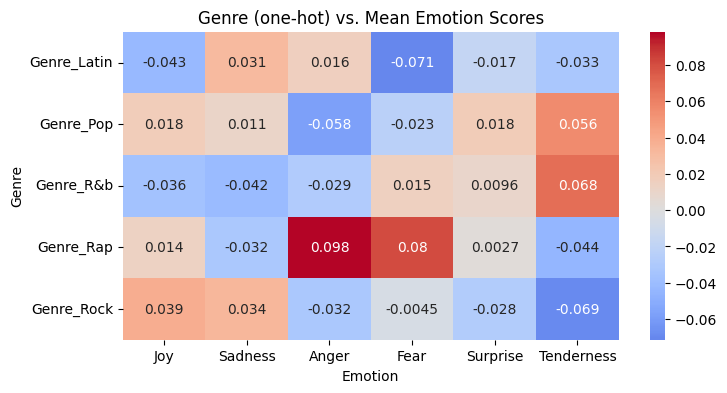

In [6]:
# 4.1 One‐hot encode a few top genres (for demonstration)
#    You can keep only the top‐5 genres by frequency to avoid too many columns
top_genres = df["playlist_genre"].value_counts().nlargest(5).index.tolist()
df_top = df[df["playlist_genre"].isin(top_genres)].copy()
df_top = pd.get_dummies(df_top, columns=["playlist_genre"], prefix="Genre")

# 4.2 Compute correlation between each one‐hot genre column and each emotion
genre_cols = [c for c in df_top.columns if c.startswith("Genre_")]
corr2 = pd.concat([df_top[genre_cols], df_top[emotion_cols]], axis=1).corr().loc[genre_cols, emotion_cols]

plt.figure(figsize=(8,4))
sns.heatmap(corr2, annot=True, cmap="coolwarm", center=0)
plt.title("Genre (one-hot) vs. Mean Emotion Scores")
plt.xlabel("Emotion")
plt.ylabel("Genre")
plt.show()

### Interpretation of Genre → Emotion Correlations  
- **Rows:** Top genres (e.g., Pop, Rock, Rap, R&B, EDM)  
- **Columns:** Emotions (Joy … Tenderness)  
- **Positive correlation:** Songs in that genre tend to have higher average scores for a given emotion.  
- **Negative correlation:** Songs in that genre tend to have lower average scores for that emotion.  

This suggests that including `playlist_genre` features (one‐hot vectors) alongside lyrics embeddings may improve regression performance.  


## 5️⃣ Preprocessing & Input Construction  
We will now:
1. Drop any remaining missing  
2. Build a single “input_text” column by concatenating Title, Genre, Artist, and cleaned Lyrics  
3. Create `inputs` (list of text) and `labels` (6‐column float array)  


In [7]:
# 5.1 Already dropped missing above. We now concatenate columns:
def make_input_text(row):
    return (
        f"Title: {row.track_name} | "
        f"Genre: {row.playlist_genre} | "
        f"Artist: {row.artist_name} | "
        f"Lyrics: {row.lyrics_clean}"
    )

df["input_text"] = df.apply(make_input_text, axis=1)

# 5.2 Prepare X and ground truth y
inputs = df["input_text"].tolist()
labels = df[emotion_cols].to_numpy(dtype=float)

# 5.3 Quick sanity check
print("Example Input (first 200 characters):")
print(inputs[0][:200] + "…")
print("\nExample Labels (first song):", labels[0])


Example Input (first 200 characters):
Title: never forget you | Genre: Pop | Artist: Zara Larsson | Lyrics: i used to be so happy but without here i feel so low  i watched you as you left but i can never seem to let you go  'cause once up…

Example Labels (first song): [1.1665 1.     0.8335 0.6665 0.5    1.167 ]


## 6️⃣ Train/Validation/Test Split  
We will split **15%** of the data as a held‐out test set, then split the remaining 85% into 70% train / 15% val.  


In [8]:
# 6.1 First split off 15% for test
inputs_tmp, inputs_test, labels_tmp, labels_test = train_test_split(
    inputs, labels, test_size=0.15, random_state=42
)

# 6.2 Split the remaining 85% into 70% train / 15% val
val_ratio = 0.15 / 0.85  # ≈0.1765
inputs_train, inputs_val, labels_train, labels_val = train_test_split(
    inputs_tmp, labels_tmp, test_size=val_ratio, random_state=42
)

# 6.3 Verify sizes
total = len(inputs)
print(f"Train:      {len(inputs_train)} ({len(inputs_train)/total:.1%})")
print(f"Validation: {len(inputs_val)} ({len(inputs_val)/total:.1%})")
print(f"Test:       {len(inputs_test)} ({len(inputs_test)/total:.1%})")


Train:      347 (69.8%)
Validation: 75 (15.1%)
Test:       75 (15.1%)


## 7️⃣ Baseline Predictor – “Predict the Training Mean”  
A simple baseline that for every test example predicts the **mean** of each emotion from the training set.  
Compute overall MSE/MAE and per‐emotion MSE/MAE, then save predictions and truths to CSV for later comparison.  


In [9]:
# 7.1 Compute training‐mean for each emotion
train_means = labels_train.mean(axis=0)  # shape=(6,)
print("Training means:", dict(zip(emotion_cols, train_means.tolist())), "\n")

# 7.2 Build constant preds for test set
baseline_preds = np.tile(train_means, (len(labels_test),1))

# 7.3 Overall metrics
mse_baseline = mean_squared_error(labels_test, baseline_preds)
mae_baseline = mean_absolute_error(labels_test, baseline_preds)
print(f"Baseline → Overall MSE: {mse_baseline:.4f}, MAE: {mae_baseline:.4f}\n")

# 7.4 Per‐emotion metrics
baseline_per = {}
for i, emo in enumerate(emotion_cols):
    m_i = mean_squared_error(labels_test[:,i], baseline_preds[:,i])
    a_i = mean_absolute_error(labels_test[:,i], baseline_preds[:,i])
    baseline_per[emo] = (m_i, a_i)
    print(f"{emo:12s}→ MSE: {m_i:.4f}, MAE: {a_i:.4f}")

# 7.5 Save predictions & truths to CSV
pd.DataFrame(baseline_preds, columns=emotion_cols).to_csv("baseline_preds.csv", index=False)
pd.DataFrame(labels_test, columns=emotion_cols).to_csv("baseline_truth.csv", index=False)
print("\nSaved baseline_preds.csv and baseline_truth.csv")


Training means: {'Joy': 0.8309394812680099, 'Sadness': 0.7161167146974062, 'Anger': 0.6969106628242075, 'Fear': 0.7007608069164268, 'Surprise': 0.7377463976945241, 'Tenderness': 0.7728184438040351} 

Baseline → Overall MSE: 0.1511, MAE: 0.3335

Joy         → MSE: 0.1760, MAE: 0.3586
Sadness     → MSE: 0.1757, MAE: 0.3723
Anger       → MSE: 0.1443, MAE: 0.3243
Fear        → MSE: 0.1460, MAE: 0.3300
Surprise    → MSE: 0.1011, MAE: 0.2658
Tenderness  → MSE: 0.1633, MAE: 0.3497

Saved baseline_preds.csv and baseline_truth.csv


## 8️⃣ Fine‐Tuning Models (BERT & RoBERTa)  
We will:
1. Define two “bare‐bones” regression heads (for BERT and for RoBERTa).  
2. Use a small grid of hyperparameters (learning rate, batch size, number of epochs).  
3. Perform simple cross‐validation (KFold=3) on the training + validation sets to pick the best combo.  
4. Re‐train the chosen model on the combined train+val split and evaluate on the held‐out test set.  


### 8.1.1 Define a “BERT → Regressor” model  


In [10]:
class BertForMultiRegression(BertPreTrainedModel):
    def __init__(self, config, hidden_dim=256, dropout_prob=0.3):
        super().__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden = nn.Linear(config.hidden_size, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, len(emotion_cols))
        self.relu = nn.ReLU()
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output           # shape=(batch, hidden_size)
        x = self.hidden(pooled)                  # shape=(batch, hidden_dim)
        x = self.relu(x)
        x = self.dropout(x)
        preds = self.regressor(x)                # shape=(batch, 6)
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(preds, labels)
        return {"loss": loss, "logits": preds}


### 8.1.2 Define a PyTorch Dataset Wrapper for BERT Inputs  


In [11]:
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class LyricsRegressionDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length=512):
        self.encodings = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }
        return item


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### 8.1.3 Grid‐Search + Cross‐Validation for BERT  
We will try a small grid of hyperparameters:  
- learning_rate ∈ [2e‐5, 3e‐5, 5e-6]  
- batch_size ∈ [4, 8, 16]  
- num_train_epochs ∈ [2, 4, 8]  

Use KFold(n_splits=3) on the **train + val** split to pick the best combo (lowest avg validation loss).


In [12]:
# 8.1.3a Prepare combined train+val for CV
X_combined = inputs_train + inputs_val
y_combined = np.vstack([labels_train, labels_val])
n_total = len(X_combined)

# 8.1.3b KFold setup
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# 8.1.3c Hyperparameter grid
param_grid = {
    "learning_rate": [1e-5, 2e-5, 3e-5, 4e-5],
    "per_device_train_batch_size": [4, 8, 16],
    "num_train_epochs": [2, 3, 5, 8],
    'weight_decay': [0.01, 0.05, 0.1]
}

grid = list(ParameterGrid(param_grid))
print("Total hyperparameter combos to try:", len(grid))

# 8.1.3d Helper to run one CV trial
def run_bert_cv(params):
    """Returns average validation loss across folds."""
    val_losses = []
    for train_idx, val_idx in kf.split(X_combined):
        # Prepare splits for this fold
        X_tr = [X_combined[i] for i in train_idx]
        y_tr = y_combined[train_idx]
        X_va = [X_combined[i] for i in val_idx]
        y_va = y_combined[val_idx]

        # Create Datasets
        train_ds_cv = LyricsRegressionDataset(X_tr, y_tr, bert_tokenizer, max_length=512)
        val_ds_cv   = LyricsRegressionDataset(X_va, y_va, bert_tokenizer, max_length=512)

        # TrainingArguments for this fold
        args = TrainingArguments(
            output_dir="tmp_cv",
            eval_strategy="epoch",
            save_strategy="no",
            learning_rate=params["learning_rate"],
            per_device_train_batch_size=params["per_device_train_batch_size"],
            per_device_eval_batch_size=params["per_device_train_batch_size"],
            num_train_epochs=params["num_train_epochs"],
            logging_strategy="no",
            weight_decay=params['weight_decay']
        )

        # Instantiate fresh model each fold
        cfg  = BertConfig.from_pretrained("bert-base-uncased")
        model = BertForMultiRegression.from_pretrained("bert-base-uncased", config=cfg).to(device)

        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds_cv,
            eval_dataset=val_ds_cv
        )

        # Train and evaluate
        trainer.train()
        metrics = trainer.evaluate()
        val_losses.append(metrics["eval_loss"])

        # Clean up to avoid GPU memory blowup
        trainer.model.cpu()
        del model, trainer
        torch.cuda.empty_cache()

    return float(np.mean(val_losses))  # average CV loss

# 8.1.3e Run the grid‐search (may take a while!)
best_score = float("inf")
best_params_bert = None

for params in grid:
    print("Testing BERT hyperparams:", params)
    avg_loss = run_bert_cv(params)
    print(f" → Avg. Val Loss = {avg_loss:.4f}\n")
    if avg_loss < best_score:
        best_score = avg_loss
        best_params_bert = params

print("🕵️‍♂️ Best BERT params:", best_params_bert, "with loss", best_score)


Total hyperparameter combos to try: 144
Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shaidahari (shaidahari-hit) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,No log,0.247649
2,No log,0.194890


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.285360
2,No log,0.223612


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281935
2,No log,0.221849


 → Avg. Val Loss = 0.2135

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293976
2,No log,0.228384


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.285452
2,No log,0.223613


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281885
2,No log,0.222419


 → Avg. Val Loss = 0.2248

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293233
2,No log,0.228295


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.285387
2,No log,0.223603


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281963
2,No log,0.222428


 → Avg. Val Loss = 0.2248

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.432778
2,No log,0.358787


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.414160
2,No log,0.347154


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.420364
2,No log,0.347235


 → Avg. Val Loss = 0.3511

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.432781
2,No log,0.358795


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.414171
2,No log,0.347178


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.420220
2,No log,0.347205


 → Avg. Val Loss = 0.3511

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.432785
2,No log,0.358794


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.414258
2,No log,0.347293


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.420224
2,No log,0.347212


 → Avg. Val Loss = 0.3511

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.567042
2,No log,0.498581


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.541621
2,No log,0.478557


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.539454
2,No log,0.478649


 → Avg. Val Loss = 0.4853

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.567070
2,No log,0.498553


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.541622
2,No log,0.478558


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.539455
2,No log,0.478629


 → Avg. Val Loss = 0.4852

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.567071
2,No log,0.498555


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.541623
2,No log,0.478561


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.539506
2,No log,0.478672


 → Avg. Val Loss = 0.4853

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.268691
2,No log,0.181949
3,No log,0.166267


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283588
2,No log,0.199270
3,No log,0.183362


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281830
2,No log,0.193080
3,No log,0.177212


 → Avg. Val Loss = 0.1756

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.292918
2,No log,0.199952
3,No log,0.183777


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283594
2,No log,0.199267
3,No log,0.183414


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281619
2,No log,0.192595
3,No log,0.176976


 → Avg. Val Loss = 0.1814

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.292906
2,No log,0.199961
3,No log,0.183809


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283931
2,No log,0.199369
3,No log,0.183464


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281761
2,No log,0.192838
3,No log,0.177053


 → Avg. Val Loss = 0.1814

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.407780
2,No log,0.308820
3,No log,0.283737


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.397394
2,No log,0.305580
3,No log,0.280797


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.394806
2,No log,0.302307
3,No log,0.277793


 → Avg. Val Loss = 0.2808

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.407786
2,No log,0.308832
3,No log,0.283745


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.397400
2,No log,0.305599
3,No log,0.280802


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.394811
2,No log,0.302312
3,No log,0.277837


 → Avg. Val Loss = 0.2808

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.407793
2,No log,0.308794
3,No log,0.283765


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.397679
2,No log,0.305647
3,No log,0.280870


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.394816
2,No log,0.302351
3,No log,0.277856


 → Avg. Val Loss = 0.2808

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.508998
2,No log,0.425495
3,No log,0.402425


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.495947
2,No log,0.416105
3,No log,0.393069


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.499414
2,No log,0.416429
3,No log,0.394636


 → Avg. Val Loss = 0.3967

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.509000
2,No log,0.425499
3,No log,0.402430


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.495948
2,No log,0.416110
3,No log,0.393076


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.499398
2,No log,0.416442
3,No log,0.394652


 → Avg. Val Loss = 0.3967

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.509003
2,No log,0.425517
3,No log,0.402421


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.495865
2,No log,0.416114
3,No log,0.393096


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.499398
2,No log,0.416439
3,No log,0.394659


 → Avg. Val Loss = 0.3967

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.276593
2,No log,0.174417
3,No log,0.152156
4,No log,0.145639
5,No log,0.144654


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.234718
2,No log,0.159132
3,No log,0.148834
4,No log,0.147270
5,No log,0.146997


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.238670
2,No log,0.162113
3,No log,0.149943
4,No log,0.148270
5,No log,0.147369


 → Avg. Val Loss = 0.1463

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.232318
2,No log,0.155559
3,No log,0.143795
4,No log,0.141779
5,No log,0.141259


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.236919
2,No log,0.159119
3,No log,0.148784
4,No log,0.147240
5,No log,0.146928


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.238738
2,No log,0.161917
3,No log,0.149933
4,No log,0.148397
5,No log,0.147469


 → Avg. Val Loss = 0.1452

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.232365
2,No log,0.155464
3,No log,0.143933
4,No log,0.141809
5,No log,0.141271


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235515
2,No log,0.158974
3,No log,0.148780
4,No log,0.147306
5,No log,0.146939


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.238787
2,No log,0.162223
3,No log,0.149980
4,No log,0.148393
5,No log,0.147471


 → Avg. Val Loss = 0.1452

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.346870
2,No log,0.230457
3,No log,0.185505
4,No log,0.169093
5,No log,0.163764


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.353167
2,No log,0.235293
3,No log,0.189128
4,No log,0.171738
5,No log,0.166907


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.343866
2,No log,0.229928
3,No log,0.189661
4,No log,0.174429
5,No log,0.169694


 → Avg. Val Loss = 0.1668

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.346876
2,No log,0.230480
3,No log,0.185544
4,No log,0.169232
5,No log,0.163827


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.353105
2,No log,0.235265
3,No log,0.189126
4,No log,0.171782
5,No log,0.166926


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.343896
2,No log,0.229960
3,No log,0.189671
4,No log,0.174470
5,No log,0.169729


 → Avg. Val Loss = 0.1668

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.346884
2,No log,0.230493
3,No log,0.185556
4,No log,0.169242
5,No log,0.163851


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.353105
2,No log,0.235286
3,No log,0.189132
4,No log,0.171781
5,No log,0.166949


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.343902
2,No log,0.229972
3,No log,0.189671
4,No log,0.174429
5,No log,0.169693


 → Avg. Val Loss = 0.1668

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.484759
2,No log,0.363110
3,No log,0.302480
4,No log,0.273189
5,No log,0.264452


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.480914
2,No log,0.363935
3,No log,0.304435
4,No log,0.275147
5,No log,0.266234


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.474273
2,No log,0.360773
3,No log,0.302582
4,No log,0.274611
5,No log,0.265458


 → Avg. Val Loss = 0.2654

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.484750
2,No log,0.363077
3,No log,0.302481
4,No log,0.273188
5,No log,0.264447


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.480916
2,No log,0.363953
3,No log,0.304510
4,No log,0.275211
5,No log,0.266275


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.474276
2,No log,0.360798
3,No log,0.302589
4,No log,0.274596
5,No log,0.265465


 → Avg. Val Loss = 0.2654

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.484738
2,No log,0.363073
3,No log,0.302486
4,No log,0.273195
5,No log,0.264458


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.480918
2,No log,0.363939
3,No log,0.304476
4,No log,0.275172
5,No log,0.266260


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.474278
2,No log,0.360804
3,No log,0.302602
4,No log,0.274603
5,No log,0.265478


 → Avg. Val Loss = 0.2654

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.226594
2,No log,0.150394
3,No log,0.140922
4,No log,0.141941
5,No log,0.139489
6,No log,0.140020
7,No log,0.139433
8,No log,0.139039


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190934
2,No log,0.148562
3,No log,0.146080
4,No log,0.145830
5,No log,0.147885
6,No log,0.146795
7,No log,0.146410
8,No log,0.146352


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189114
2,No log,0.147930
3,No log,0.145659
4,No log,0.146068
5,No log,0.145656
6,No log,0.147146
7,No log,0.146387
8,No log,0.147506


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190496
2,No log,0.144267
3,No log,0.141637
4,No log,0.140670
5,No log,0.141078
6,No log,0.140905
7,No log,0.142407
8,No log,0.140611


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190944
2,No log,0.148681
3,No log,0.146065
4,No log,0.145788
5,No log,0.148633
6,No log,0.146750
7,No log,0.146160
8,No log,0.146131


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189124
2,No log,0.147977
3,No log,0.145591
4,No log,0.145988
5,No log,0.145732
6,No log,0.146958
7,No log,0.146289
8,No log,0.147008


 → Avg. Val Loss = 0.1446

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190556
2,No log,0.144237
3,No log,0.141605
4,No log,0.140780
5,No log,0.140549
6,No log,0.140596
7,No log,0.142017
8,No log,0.140425


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190940
2,No log,0.148674
3,No log,0.146200
4,No log,0.145806
5,No log,0.149273
6,No log,0.146937
7,No log,0.146227
8,No log,0.146214


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189109
2,No log,0.147987
3,No log,0.145644
4,No log,0.145988
5,No log,0.145678
6,No log,0.146775
7,No log,0.146274
8,No log,0.147078


 → Avg. Val Loss = 0.1446

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.280799
2,No log,0.184557
3,No log,0.151753
4,No log,0.144104
5,No log,0.142836
6,No log,0.141413
7,No log,0.141309
8,No log,0.140254


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.275005
2,No log,0.183180
3,No log,0.154770
4,No log,0.148120
5,No log,0.146503
6,No log,0.146330
7,No log,0.146374
8,No log,0.146198


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271239
2,No log,0.181054
3,No log,0.152471
4,No log,0.147259
5,No log,0.146550
6,No log,0.146929
7,No log,0.146375
8,No log,0.146697


 → Avg. Val Loss = 0.1444

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.280806
2,No log,0.184568
3,No log,0.151751
4,No log,0.144165
5,No log,0.142801
6,No log,0.141462
7,No log,0.141333
8,No log,0.140272


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.275012
2,No log,0.183189
3,No log,0.154779
4,No log,0.148116
5,No log,0.146490
6,No log,0.146304
7,No log,0.146357
8,No log,0.146186


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271246
2,No log,0.181063
3,No log,0.152483
4,No log,0.147187
5,No log,0.146469
6,No log,0.146747
7,No log,0.146333
8,No log,0.146596


 → Avg. Val Loss = 0.1444

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.280815
2,No log,0.184574
3,No log,0.151753
4,No log,0.144187
5,No log,0.142823
6,No log,0.141245
7,No log,0.141375
8,No log,0.140231


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.275008
2,No log,0.183203
3,No log,0.154783
4,No log,0.148136
5,No log,0.146495
6,No log,0.146300
7,No log,0.146341
8,No log,0.146162


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271254
2,No log,0.181075
3,No log,0.152488
4,No log,0.147237
5,No log,0.146406
6,No log,0.146659
7,No log,0.146399
8,No log,0.146646


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.387071
2,No log,0.281698
3,No log,0.225947
4,No log,0.191652
5,No log,0.172684
6,No log,0.162639
7,No log,0.157940
8,No log,0.156514


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.367517
2,No log,0.272640
3,No log,0.221556
4,No log,0.191731
5,No log,0.174396
6,No log,0.165507
7,No log,0.161372
8,No log,0.160174


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.363530
2,No log,0.269775
3,No log,0.218826
4,No log,0.188785
5,No log,0.172379
6,No log,0.163752
7,No log,0.159847
8,No log,0.158578


 → Avg. Val Loss = 0.1584

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.387074
2,No log,0.281705
3,No log,0.225956
4,No log,0.191661
5,No log,0.172690
6,No log,0.162653
7,No log,0.157944
8,No log,0.156513


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.367520
2,No log,0.272632
3,No log,0.221550
4,No log,0.191754
5,No log,0.174372
6,No log,0.165518
7,No log,0.161344
8,No log,0.160151


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.363533
2,No log,0.269781
3,No log,0.218822
4,No log,0.188814
5,No log,0.172359
6,No log,0.163732
7,No log,0.159845
8,No log,0.158578


 → Avg. Val Loss = 0.1584

Testing BERT hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.387078
2,No log,0.281713
3,No log,0.225967
4,No log,0.191674
5,No log,0.172706
6,No log,0.162659
7,No log,0.157954
8,No log,0.156515


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.367524
2,No log,0.272650
3,No log,0.221562
4,No log,0.191741
5,No log,0.174389
6,No log,0.165526
7,No log,0.161357
8,No log,0.160154


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.363537
2,No log,0.269790
3,No log,0.218868
4,No log,0.188787
5,No log,0.172389
6,No log,0.163797
7,No log,0.159895
8,No log,0.158617


 → Avg. Val Loss = 0.1584

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148801
2,No log,0.141415


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176134
2,No log,0.151961


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177475
2,No log,0.154210


 → Avg. Val Loss = 0.1492

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177202
2,No log,0.150470


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176096
2,No log,0.152208


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177515
2,No log,0.154108


 → Avg. Val Loss = 0.1523

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177252
2,No log,0.150492


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176336
2,No log,0.152214


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177294
2,No log,0.153897


 → Avg. Val Loss = 0.1522

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281301
2,No log,0.217069


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.273899
2,No log,0.213833


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282557
2,No log,0.222719


 → Avg. Val Loss = 0.2179

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281316
2,No log,0.217069


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.274164
2,No log,0.213829


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282234
2,No log,0.222540


 → Avg. Val Loss = 0.2178

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.281337
2,No log,0.217115


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.274093
2,No log,0.213811


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282668
2,No log,0.222486


 → Avg. Val Loss = 0.2178

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.432126
2,No log,0.354692


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.428479
2,No log,0.352984


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.416778
2,No log,0.338577


 → Avg. Val Loss = 0.3488

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.432113
2,No log,0.354666


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.428489
2,No log,0.353023


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.416782
2,No log,0.338591


 → Avg. Val Loss = 0.3488

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.432117
2,No log,0.354663


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.428498
2,No log,0.353031


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.416787
2,No log,0.338608


 → Avg. Val Loss = 0.3488

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.162427
2,No log,0.141224
3,No log,0.140177


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173434
2,No log,0.147851
3,No log,0.146310


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.170629
2,No log,0.146378
3,No log,0.146243


 → Avg. Val Loss = 0.1442

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176806
2,No log,0.142354
3,No log,0.140964


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173446
2,No log,0.147878
3,No log,0.146321


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.170687
2,No log,0.146427
3,No log,0.146237


 → Avg. Val Loss = 0.1445

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176717
2,No log,0.142211
3,No log,0.141014


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173462
2,No log,0.147991
3,No log,0.146323


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.170704
2,No log,0.146452
3,No log,0.146247


 → Avg. Val Loss = 0.1445

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.276313
2,No log,0.182201
3,No log,0.166587


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.276998
2,No log,0.186481
3,No log,0.169901


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.275729
2,No log,0.185152
3,No log,0.168921


 → Avg. Val Loss = 0.1685

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.276315
2,No log,0.182192
3,No log,0.166559


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.277007
2,No log,0.186489
3,No log,0.169906


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.275740
2,No log,0.185135
3,No log,0.168928


 → Avg. Val Loss = 0.1685

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.276278
2,No log,0.182225
3,No log,0.166600


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.277020
2,No log,0.186524
3,No log,0.169942


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.275753
2,No log,0.185163
3,No log,0.168930


 → Avg. Val Loss = 0.1685

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.403588
2,No log,0.305842
3,No log,0.278397


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.391100
2,No log,0.300214
3,No log,0.274231


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.388478
2,No log,0.297847
3,No log,0.272747


 → Avg. Val Loss = 0.2751

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.403723
2,No log,0.305839
3,No log,0.278644


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.391105
2,No log,0.300224
3,No log,0.274241


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.388598
2,No log,0.297919
3,No log,0.272817


 → Avg. Val Loss = 0.2752

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.403724
2,No log,0.305678
3,No log,0.278522


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.391111
2,No log,0.300271
3,No log,0.274243


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.388542
2,No log,0.297857
3,No log,0.272781


 → Avg. Val Loss = 0.2752

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.166050
2,No log,0.140543
3,No log,0.139989
4,No log,0.140224
5,No log,0.139844


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.157079
2,No log,0.147489
3,No log,0.146763
4,No log,0.145244
5,No log,0.145253


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.157571
2,No log,0.146723
3,No log,0.146201
4,No log,0.145930
5,No log,0.145733


 → Avg. Val Loss = 0.1436

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146349
2,No log,0.140989
3,No log,0.138989
4,No log,0.139957
5,No log,0.140074


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.156739
2,No log,0.147000
3,No log,0.146659
4,No log,0.145810
5,No log,0.145672


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.157582
2,No log,0.147191
3,No log,0.145462
4,No log,0.146396
5,No log,0.145493


 → Avg. Val Loss = 0.1437

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145928
2,No log,0.141283
3,No log,0.138909
4,No log,0.139941
5,No log,0.139748


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.156248
2,No log,0.147905
3,No log,0.146462
4,No log,0.145954
5,No log,0.145701


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.157624
2,No log,0.147946
3,No log,0.145222
4,No log,0.146504
5,No log,0.145707


 → Avg. Val Loss = 0.1437

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.225726
2,No log,0.146858
3,No log,0.139795
4,No log,0.139447
5,No log,0.139839


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.233925
2,No log,0.157145
3,No log,0.147113
4,No log,0.146657
5,No log,0.146662


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.228148
2,No log,0.154203
3,No log,0.147803
4,No log,0.145631
5,No log,0.145679


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.226728
2,No log,0.146099
3,No log,0.140332
4,No log,0.139520
5,No log,0.140122


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.232650
2,No log,0.157003
3,No log,0.147324
4,No log,0.146669
5,No log,0.146364


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.228221
2,No log,0.154180
3,No log,0.147741
4,No log,0.145490
5,No log,0.145890


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.226614
2,No log,0.146145
3,No log,0.140079
4,No log,0.139379
5,No log,0.139853


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.232536
2,No log,0.156403
3,No log,0.147026
4,No log,0.146623
5,No log,0.146536


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.228245
2,No log,0.154051
3,No log,0.147791
4,No log,0.145427
5,No log,0.145833


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.379263
2,No log,0.240908
3,No log,0.185986
4,No log,0.165294
5,No log,0.160891


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.358755
2,No log,0.236004
3,No log,0.188754
4,No log,0.171101
5,No log,0.166321


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.365602
2,No log,0.238459
3,No log,0.189857
4,No log,0.171556
5,No log,0.166742


 → Avg. Val Loss = 0.1647

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.379266
2,No log,0.240918
3,No log,0.185982
4,No log,0.165302
5,No log,0.160889


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.358697
2,No log,0.235601
3,No log,0.188613
4,No log,0.170576
5,No log,0.165767


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.365608
2,No log,0.238454
3,No log,0.189867
4,No log,0.171566
5,No log,0.166750


 → Avg. Val Loss = 0.1645

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.379271
2,No log,0.240929
3,No log,0.186014
4,No log,0.165323
5,No log,0.160916


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.358609
2,No log,0.235621
3,No log,0.188672
4,No log,0.170917
5,No log,0.166035


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.365610
2,No log,0.238475
3,No log,0.189883
4,No log,0.171587
5,No log,0.166761


 → Avg. Val Loss = 0.1646

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.143603
2,No log,0.146641
3,No log,0.138744
4,No log,0.140331
5,No log,0.140100
6,No log,0.137639
7,No log,0.139038
8,No log,0.139146


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150681
2,No log,0.147527
3,No log,0.145970
4,No log,0.146438
5,No log,0.150401
6,No log,0.146792
7,No log,0.146442
8,No log,0.146635


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145941
2,No log,0.147242
3,No log,0.145716
4,No log,0.146532
5,No log,0.146520
6,No log,0.146767
7,No log,0.146674
8,No log,0.146989


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141965
2,No log,0.142215
3,No log,0.141548
4,No log,0.141497
5,No log,0.142338
6,No log,0.141834
7,No log,0.146306
8,No log,0.145404


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150605
2,No log,0.147439
3,No log,0.145898
4,No log,0.146539
5,No log,0.151696
6,No log,0.146919
7,No log,0.147092
8,No log,0.147285


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145896
2,No log,0.147619
3,No log,0.145782
4,No log,0.147732
5,No log,0.146847
6,No log,0.146740
7,No log,0.146954
8,No log,0.147300


 → Avg. Val Loss = 0.1467

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142250
2,No log,0.142098
3,No log,0.141929
4,No log,0.140783
5,No log,0.144999
6,No log,0.141301
7,No log,0.143271
8,No log,0.143834


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150681
2,No log,0.147694
3,No log,0.146103
4,No log,0.146353
5,No log,0.149514
6,No log,0.146891
7,No log,0.146570
8,No log,0.146780


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145916
2,No log,0.147711
3,No log,0.145721
4,No log,0.146192
5,No log,0.146352
6,No log,0.146936
7,No log,0.146650
8,No log,0.146848


 → Avg. Val Loss = 0.1458

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178881
2,No log,0.143591
3,No log,0.139211
4,No log,0.140309
5,No log,0.140570
6,No log,0.140417
7,No log,0.139679
8,No log,0.139671


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.180656
2,No log,0.146503
3,No log,0.147386
4,No log,0.146500
5,No log,0.146292
6,No log,0.147978
7,No log,0.147437
8,No log,0.147127


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176971
2,No log,0.148059
3,No log,0.144716
4,No log,0.146005
5,No log,0.146045
6,No log,0.146091
7,No log,0.146422
8,No log,0.146836


 → Avg. Val Loss = 0.1445

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178891
2,No log,0.143616
3,No log,0.139149
4,No log,0.140087
5,No log,0.140403
6,No log,0.140748
7,No log,0.139431
8,No log,0.139348


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.180673
2,No log,0.146471
3,No log,0.147331
4,No log,0.146280
5,No log,0.148909
6,No log,0.146447
7,No log,0.147038
8,No log,0.147121


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176980
2,No log,0.147899
3,No log,0.144826
4,No log,0.146154
5,No log,0.145963
6,No log,0.146212
7,No log,0.146658
8,No log,0.147785


 → Avg. Val Loss = 0.1448

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178904
2,No log,0.143638
3,No log,0.139297
4,No log,0.140067
5,No log,0.140450
6,No log,0.140384
7,No log,0.140064
8,No log,0.139524


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.180672
2,No log,0.146461
3,No log,0.147222
4,No log,0.146240
5,No log,0.148818
6,No log,0.146399
7,No log,0.146944
8,No log,0.146988


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176989
2,No log,0.148036
3,No log,0.144833
4,No log,0.146127
5,No log,0.145727
6,No log,0.146290
7,No log,0.146696
8,No log,0.147745


 → Avg. Val Loss = 0.1448

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.280696
2,No log,0.176293
3,No log,0.144699
4,No log,0.139873
5,No log,0.141434
6,No log,0.140783
7,No log,0.140872
8,No log,0.140126


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.269057
2,No log,0.177037
3,No log,0.149445
4,No log,0.147027
5,No log,0.149060
6,No log,0.146003
7,No log,0.146063
8,No log,0.146083


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.265269
2,No log,0.173311
3,No log,0.147920
4,No log,0.145498
5,No log,0.149416
6,No log,0.145486
7,No log,0.146099
8,No log,0.146114


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.280703
2,No log,0.176306
3,No log,0.144695
4,No log,0.139857
5,No log,0.141446
6,No log,0.140697
7,No log,0.141082
8,No log,0.140545


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.269063
2,No log,0.177038
3,No log,0.149450
4,No log,0.147057
5,No log,0.148926
6,No log,0.145981
7,No log,0.146046
8,No log,0.146045


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.265278
2,No log,0.173327
3,No log,0.147899
4,No log,0.145439
5,No log,0.148315
6,No log,0.145549
7,No log,0.146224
8,No log,0.146150


 → Avg. Val Loss = 0.1442

Testing BERT hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.280731
2,No log,0.176262
3,No log,0.144844
4,No log,0.139970
5,No log,0.141617
6,No log,0.140657
7,No log,0.141240
8,No log,0.140553


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.269093
2,No log,0.177057
3,No log,0.149476
4,No log,0.147043
5,No log,0.147373
6,No log,0.145918
7,No log,0.145961
8,No log,0.145941


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.265287
2,No log,0.173341
3,No log,0.147895
4,No log,0.145465
5,No log,0.149270
6,No log,0.145467
7,No log,0.145935
8,No log,0.145902


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140607
2,No log,0.139219


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150385
2,No log,0.145847


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150485
2,No log,0.147323


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142658
2,No log,0.139698


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150583
2,No log,0.146041


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150635
2,No log,0.147425


 → Avg. Val Loss = 0.1444

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142799
2,No log,0.139706


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150525
2,No log,0.145974


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150776
2,No log,0.147459


 → Avg. Val Loss = 0.1444

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.202331
2,No log,0.158565


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.201126
2,No log,0.160794


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199122
2,No log,0.158777


 → Avg. Val Loss = 0.1594

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.202337
2,No log,0.158604


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.201079
2,No log,0.160811


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.200633
2,No log,0.158748


 → Avg. Val Loss = 0.1594

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.202353
2,No log,0.158764


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.201327
2,No log,0.160831


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.200942
2,No log,0.158736


 → Avg. Val Loss = 0.1594

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.346210
2,No log,0.268994


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.342886
2,No log,0.271437


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.316642
2,No log,0.251791


 → Avg. Val Loss = 0.2641

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.346211
2,No log,0.269127


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.342899
2,No log,0.271370


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.316650
2,No log,0.251800


 → Avg. Val Loss = 0.2641

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.346209
2,No log,0.269215


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.342887
2,No log,0.271350


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.316659
2,No log,0.251795


 → Avg. Val Loss = 0.2641

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140113
2,No log,0.141249
3,No log,0.139418


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151659
2,No log,0.145846
3,No log,0.145677


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148070
2,No log,0.146896
3,No log,0.146002


 → Avg. Val Loss = 0.1437

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.143284
2,No log,0.139420
3,No log,0.140121


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151788
2,No log,0.145790
3,No log,0.146007


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148168
2,No log,0.146733
3,No log,0.146015


 → Avg. Val Loss = 0.1440

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.143331
2,No log,0.139534
3,No log,0.140058


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151964
2,No log,0.145935
3,No log,0.145604


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148122
2,No log,0.146718
3,No log,0.145990


 → Avg. Val Loss = 0.1439

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199855
2,No log,0.143669
3,No log,0.141569


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.203764
2,No log,0.149357
3,No log,0.146749


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199644
2,No log,0.149023
3,No log,0.146677


 → Avg. Val Loss = 0.1450

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199870
2,No log,0.143570
3,No log,0.141415


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199931
2,No log,0.149404
3,No log,0.146509


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199661
2,No log,0.148988
3,No log,0.146702


 → Avg. Val Loss = 0.1449

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199897
2,No log,0.143588
3,No log,0.141489


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199969
2,No log,0.149355
3,No log,0.146514


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.199533
2,No log,0.149334
3,No log,0.146894


 → Avg. Val Loss = 0.1450

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.335398
2,No log,0.228882
3,No log,0.203835


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.321220
2,No log,0.225342
3,No log,0.201645


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.323372
2,No log,0.225040
3,No log,0.202005


 → Avg. Val Loss = 0.2025

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.335407
2,No log,0.228906
3,No log,0.203862


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.321229
2,No log,0.225369
3,No log,0.201647


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.323371
2,No log,0.225052
3,No log,0.202017


 → Avg. Val Loss = 0.2025

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.335419
2,No log,0.228929
3,No log,0.203880


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.321240
2,No log,0.225366
3,No log,0.201658


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.323381
2,No log,0.225062
3,No log,0.202018


 → Avg. Val Loss = 0.2025

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141440
2,No log,0.139899
3,No log,0.138513
4,No log,0.140146
5,No log,0.140397


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.154345
2,No log,0.146758
3,No log,0.148369
4,No log,0.146002
5,No log,0.145886


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148858
2,No log,0.150089
3,No log,0.145577
4,No log,0.146502
5,No log,0.146195


 → Avg. Val Loss = 0.1442

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.137777
2,No log,0.145838
3,No log,0.138981
4,No log,0.139724
5,No log,0.138872


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148610
2,No log,0.146592
3,No log,0.146548
4,No log,0.145804
5,No log,0.145899


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148867
2,No log,0.151018
3,No log,0.145883
4,No log,0.146370
5,No log,0.146023


 → Avg. Val Loss = 0.1436

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.137704
2,No log,0.144441
3,No log,0.139093
4,No log,0.140748
5,No log,0.139963


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149493
2,No log,0.149833
3,No log,0.146884
4,No log,0.145658
5,No log,0.145783


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148822
2,No log,0.147264
3,No log,0.145062
4,No log,0.147404
5,No log,0.145471


 → Avg. Val Loss = 0.1437

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.165501
2,No log,0.143235
3,No log,0.140611
4,No log,0.140510
5,No log,0.140505


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173127
2,No log,0.146461
3,No log,0.147983
4,No log,0.146510
5,No log,0.146261


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.169183
2,No log,0.148759
3,No log,0.145641
4,No log,0.145256
5,No log,0.145343


 → Avg. Val Loss = 0.1440

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.165772
2,No log,0.151396
3,No log,0.138255
4,No log,0.141016
5,No log,0.139617


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173077
2,No log,0.146478
3,No log,0.147700
4,No log,0.146489
5,No log,0.146236


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.169195
2,No log,0.148697
3,No log,0.146271
4,No log,0.145447
5,No log,0.145565


 → Avg. Val Loss = 0.1438

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.165813
2,No log,0.152388
3,No log,0.138493
4,No log,0.141168
5,No log,0.139605


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173093
2,No log,0.146458
3,No log,0.147825
4,No log,0.146538
5,No log,0.146214


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.169206
2,No log,0.148437
3,No log,0.146438
4,No log,0.145418
5,No log,0.145510


 → Avg. Val Loss = 0.1438

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293592
2,No log,0.173079
3,No log,0.144833
4,No log,0.139863
5,No log,0.139965


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289757
2,No log,0.179570
3,No log,0.152378
4,No log,0.147527
5,No log,0.146556


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282129
2,No log,0.176828
3,No log,0.152477
4,No log,0.146998
5,No log,0.146380


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293606
2,No log,0.173212
3,No log,0.145057
4,No log,0.139875
5,No log,0.139662


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289999
2,No log,0.178879
3,No log,0.151964
4,No log,0.147529
5,No log,0.146565


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282102
2,No log,0.176864
3,No log,0.152333
4,No log,0.147066
5,No log,0.146375


 → Avg. Val Loss = 0.1442

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293501
2,No log,0.172943
3,No log,0.145377
4,No log,0.140182
5,No log,0.139729


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289168
2,No log,0.178668
3,No log,0.151942
4,No log,0.147513
5,No log,0.146762


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282719
2,No log,0.176713
3,No log,0.152487
4,No log,0.147199
5,No log,0.146517


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.137949
2,No log,0.146293
3,No log,0.139859
4,No log,0.141811
5,No log,0.140626
6,No log,0.138521
7,No log,0.142139
8,No log,0.142067


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147222
2,No log,0.149620
3,No log,0.146435
4,No log,0.146472
5,No log,0.148976
6,No log,0.146749
7,No log,0.146308
8,No log,0.146337


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145894
2,No log,0.148115
3,No log,0.145737
4,No log,0.146359
5,No log,0.146846
6,No log,0.146384
7,No log,0.146449
8,No log,0.146986


 → Avg. Val Loss = 0.1451

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140238
2,No log,0.142311
3,No log,0.142867
4,No log,0.141309
5,No log,0.141635
6,No log,0.140805
7,No log,0.142020
8,No log,0.141510


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147415
2,No log,0.150041
3,No log,0.146849
4,No log,0.146438
5,No log,0.150498
6,No log,0.146701
7,No log,0.146365
8,No log,0.146401


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145938
2,No log,0.148162
3,No log,0.145674
4,No log,0.146430
5,No log,0.147003
6,No log,0.146735
7,No log,0.147170
8,No log,0.148198


 → Avg. Val Loss = 0.1454

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140255
2,No log,0.141336
3,No log,0.142284
4,No log,0.140315
5,No log,0.142363
6,No log,0.140760
7,No log,0.142766
8,No log,0.142595


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147240
2,No log,0.148684
3,No log,0.146721
4,No log,0.146430
5,No log,0.149527
6,No log,0.146589
7,No log,0.146551
8,No log,0.146670


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146061
2,No log,0.149083
3,No log,0.146214
4,No log,0.147315
5,No log,0.147610
6,No log,0.150824
7,No log,0.149357
8,No log,0.149769


 → Avg. Val Loss = 0.1463

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.143640
2,No log,0.141858
3,No log,0.138580
4,No log,0.141679
5,No log,0.140703
6,No log,0.141657
7,No log,0.141315
8,No log,0.140911


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150540
2,No log,0.146755
3,No log,0.147055
4,No log,0.146834
5,No log,0.147305
6,No log,0.146681
7,No log,0.146393
8,No log,0.146274


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147445
2,No log,0.148570
3,No log,0.144600
4,No log,0.148077
5,No log,0.146544
6,No log,0.147422
7,No log,0.148888
8,No log,0.148979


 → Avg. Val Loss = 0.1454

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.143642
2,No log,0.141842
3,No log,0.138702
4,No log,0.141997
5,No log,0.140546
6,No log,0.141278
7,No log,0.141342
8,No log,0.140896


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150525
2,No log,0.146913
3,No log,0.148094
4,No log,0.146205
5,No log,0.146323
6,No log,0.146961
7,No log,0.147276
8,No log,0.147455


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147477
2,No log,0.148465
3,No log,0.144738
4,No log,0.148174
5,No log,0.147090
6,No log,0.147533
7,No log,0.149624
8,No log,0.149450


 → Avg. Val Loss = 0.1459

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.143654
2,No log,0.141777
3,No log,0.138703
4,No log,0.141601
5,No log,0.140545
6,No log,0.141028
7,No log,0.140820
8,No log,0.139948


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150531
2,No log,0.146904
3,No log,0.147408
4,No log,0.146902
5,No log,0.147162
6,No log,0.146033
7,No log,0.146199
8,No log,0.145751


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147492
2,No log,0.148689
3,No log,0.144713
4,No log,0.148346
5,No log,0.146909
6,No log,0.148098
7,No log,0.149478
8,No log,0.149666


 → Avg. Val Loss = 0.1451

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.214080
2,No log,0.140712
3,No log,0.138683
4,No log,0.140189
5,No log,0.140732
6,No log,0.141463
7,No log,0.140641
8,No log,0.140362


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.212004
2,No log,0.148383
3,No log,0.145843
4,No log,0.147308
5,No log,0.146417
6,No log,0.145550
7,No log,0.145819
8,No log,0.145966


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.209236
2,No log,0.146630
3,No log,0.146116
4,No log,0.146420
5,No log,0.147991
6,No log,0.147669
7,No log,0.146461
8,No log,0.146549


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.214090
2,No log,0.140715
3,No log,0.138681
4,No log,0.140199
5,No log,0.140763
6,No log,0.141405
7,No log,0.140792
8,No log,0.140399


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.212012
2,No log,0.148377
3,No log,0.145940
4,No log,0.147287
5,No log,0.146761
6,No log,0.145692
7,No log,0.145898
8,No log,0.146070


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.209244
2,No log,0.146613
3,No log,0.146089
4,No log,0.146807
5,No log,0.147591
6,No log,0.148099
7,No log,0.146200
8,No log,0.146428


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.214101
2,No log,0.140719
3,No log,0.138686
4,No log,0.140187
5,No log,0.140662
6,No log,0.141555
7,No log,0.140594
8,No log,0.140319


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.212023
2,No log,0.148250
3,No log,0.145956
4,No log,0.147009
5,No log,0.147494
6,No log,0.145641
7,No log,0.145889
8,No log,0.146031


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.209254
2,No log,0.146594
3,No log,0.146065
4,No log,0.145840
5,No log,0.148729
6,No log,0.146715
7,No log,0.146377
8,No log,0.146580


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140710
2,No log,0.139365


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148137
2,No log,0.146039


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146702
2,No log,0.146025


 → Avg. Val Loss = 0.1438

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139494
2,No log,0.138774


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148041
2,No log,0.146040


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146668
2,No log,0.146045


 → Avg. Val Loss = 0.1436

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139490
2,No log,0.138863


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148793
2,No log,0.145982


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146544
2,No log,0.146017


 → Avg. Val Loss = 0.1436

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.164300
2,No log,0.144672


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.167876
2,No log,0.147341


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.160114
2,No log,0.146637


 → Avg. Val Loss = 0.1462

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.164422
2,No log,0.145142


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.168021
2,No log,0.147514


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.160186
2,No log,0.146624


 → Avg. Val Loss = 0.1464

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.164418
2,No log,0.145085


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.166989
2,No log,0.147413


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.160198
2,No log,0.146635


 → Avg. Val Loss = 0.1464

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.288967
2,No log,0.212956


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.286393
2,No log,0.219561


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.261535
2,No log,0.201653


 → Avg. Val Loss = 0.2114

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.288953
2,No log,0.212951


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.286801
2,No log,0.219572


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.261622
2,No log,0.201653


 → Avg. Val Loss = 0.2114

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289019
2,No log,0.212991


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.286809
2,No log,0.219539


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.261659
2,No log,0.201782


 → Avg. Val Loss = 0.2114

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139124
2,No log,0.141770
3,No log,0.140230


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148566
2,No log,0.146686
3,No log,0.146091


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146446
2,No log,0.147542
3,No log,0.146791


 → Avg. Val Loss = 0.1444

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140133
2,No log,0.139802
3,No log,0.141182


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148713
2,No log,0.146509
3,No log,0.145888


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146338
2,No log,0.146803
3,No log,0.146756


 → Avg. Val Loss = 0.1446

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140170
2,No log,0.140038
3,No log,0.141146


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148628
2,No log,0.146226
3,No log,0.146019


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146507
2,No log,0.147164
3,No log,0.147182


 → Avg. Val Loss = 0.1448

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.160292
2,No log,0.139683
3,No log,0.139569


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.165977
2,No log,0.146256
3,No log,0.146048


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174739
2,No log,0.147321
3,No log,0.146705


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.160317
2,No log,0.139839
3,No log,0.139664


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.166179
2,No log,0.146275
3,No log,0.146015


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174802
2,No log,0.147325
3,No log,0.146726


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.160318
2,No log,0.139607
3,No log,0.139710


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.166091
2,No log,0.146282
3,No log,0.145963


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174936
2,No log,0.147404
3,No log,0.146756


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283402
2,No log,0.181672
3,No log,0.162960


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.270116
2,No log,0.180715
3,No log,0.163569


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.269976
2,No log,0.180589
3,No log,0.164562


 → Avg. Val Loss = 0.1637

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283420
2,No log,0.181681
3,No log,0.162964


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.270132
2,No log,0.180761
3,No log,0.163593


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.269893
2,No log,0.180674
3,No log,0.164604


 → Avg. Val Loss = 0.1637

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283432
2,No log,0.181699
3,No log,0.162984


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.270142
2,No log,0.180718
3,No log,0.163319


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.269952
2,No log,0.180725
3,No log,0.164615


 → Avg. Val Loss = 0.1636

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139753
2,No log,0.140732
3,No log,0.140587
4,No log,0.141106
5,No log,0.140904


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.152182
2,No log,0.147481
3,No log,0.148997
4,No log,0.146353
5,No log,0.145747


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150371
2,No log,0.148634
3,No log,0.145895
4,No log,0.146295
5,No log,0.145516


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140175
2,No log,0.146619
3,No log,0.139413
4,No log,0.140915
5,No log,0.139958


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150734
2,No log,0.147995
3,No log,0.149546
4,No log,0.146153
5,No log,0.145372


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150166
2,No log,0.147482
3,No log,0.145086
4,No log,0.145874
5,No log,0.145972


 → Avg. Val Loss = 0.1438

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138888
2,No log,0.142601
3,No log,0.138915
4,No log,0.141369
5,No log,0.140320


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148474
2,No log,0.147796
3,No log,0.148425
4,No log,0.146171
5,No log,0.146014


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149645
2,No log,0.147008
3,No log,0.145605
4,No log,0.145734
5,No log,0.145955


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141793
2,No log,0.140186
3,No log,0.140785
4,No log,0.141292
5,No log,0.141227


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.153087
2,No log,0.145947
3,No log,0.148198
4,No log,0.146247
5,No log,0.146131


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150249
2,No log,0.147923
3,No log,0.145745
4,No log,0.145253
5,No log,0.145457


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141788
2,No log,0.141425
3,No log,0.139492
4,No log,0.141160
5,No log,0.140844


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.153304
2,No log,0.145765
3,No log,0.147756
4,No log,0.146132
5,No log,0.145958


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150243
2,No log,0.148114
3,No log,0.145734
4,No log,0.145191
5,No log,0.145504


 → Avg. Val Loss = 0.1441

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142906
2,No log,0.140058
3,No log,0.140383
4,No log,0.140904
5,No log,0.141759


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.155206
2,No log,0.145593
3,No log,0.148217
4,No log,0.145669
5,No log,0.145739


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150236
2,No log,0.147895
3,No log,0.145689
4,No log,0.145267
5,No log,0.145480


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.239189
2,No log,0.144062
3,No log,0.139376
4,No log,0.139272
5,No log,0.140372


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235663
2,No log,0.152228
3,No log,0.145642
4,No log,0.147402
5,No log,0.147167


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235369
2,No log,0.152768
3,No log,0.147049
4,No log,0.145267
5,No log,0.145252


 → Avg. Val Loss = 0.1443

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.239275
2,No log,0.143986
3,No log,0.139248
4,No log,0.138425
5,No log,0.139302


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235674
2,No log,0.152241
3,No log,0.145739
4,No log,0.146870
5,No log,0.146229


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235610
2,No log,0.152715
3,No log,0.147050
4,No log,0.145426
5,No log,0.145473


 → Avg. Val Loss = 0.1437

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.239264
2,No log,0.144026
3,No log,0.139208
4,No log,0.139053
5,No log,0.139853


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235718
2,No log,0.152568
3,No log,0.145508
4,No log,0.147168
5,No log,0.146882


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.235340
2,No log,0.152828
3,No log,0.147730
4,No log,0.145121
5,No log,0.145041


 → Avg. Val Loss = 0.1439

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142486
2,No log,0.144999
3,No log,0.140172
4,No log,0.142068
5,No log,0.141025
6,No log,0.138726
7,No log,0.140382
8,No log,0.141795


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151934
2,No log,0.148854
3,No log,0.147709
4,No log,0.149560
5,No log,0.155664
6,No log,0.150754
7,No log,0.150544
8,No log,0.151081


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146195
2,No log,0.149311
3,No log,0.146431
4,No log,0.151762
5,No log,0.150297
6,No log,0.150492
7,No log,0.152276
8,No log,0.152937


 → Avg. Val Loss = 0.1486

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141217
2,No log,0.143214
3,No log,0.143768
4,No log,0.141668
5,No log,0.143278
6,No log,0.141381
7,No log,0.142602
8,No log,0.141933


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151862
2,No log,0.148654
3,No log,0.148159
4,No log,0.150383
5,No log,0.154434
6,No log,0.151339
7,No log,0.150895
8,No log,0.150894


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146341
2,No log,0.149515
3,No log,0.146301
4,No log,0.147389
5,No log,0.148539
6,No log,0.151429
7,No log,0.151836
8,No log,0.151917


 → Avg. Val Loss = 0.1482

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141317
2,No log,0.144302
3,No log,0.143052
4,No log,0.141200
5,No log,0.142374
6,No log,0.140800
7,No log,0.141117
8,No log,0.140919


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.152221
2,No log,0.148835
3,No log,0.147956
4,No log,0.151944
5,No log,0.150033
6,No log,0.151476
7,No log,0.151185
8,No log,0.151756


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145882
2,No log,0.149420
3,No log,0.146047
4,No log,0.148610
5,No log,0.149192
6,No log,0.150008
7,No log,0.149524
8,No log,0.150410


 → Avg. Val Loss = 0.1477

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140342
2,No log,0.142383
3,No log,0.137908
4,No log,0.140139
5,No log,0.140805
6,No log,0.142495
7,No log,0.139317
8,No log,0.142617


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148362
2,No log,0.147143
3,No log,0.148137
4,No log,0.146651
5,No log,0.146310
6,No log,0.150055
7,No log,0.149466
8,No log,0.149572


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147240
2,No log,0.148212
3,No log,0.145499
4,No log,0.147261
5,No log,0.146968
6,No log,0.147569
7,No log,0.148759
8,No log,0.149695


 → Avg. Val Loss = 0.1473

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140344
2,No log,0.142348
3,No log,0.137853
4,No log,0.140508
5,No log,0.141516
6,No log,0.141824
7,No log,0.139397
8,No log,0.143338


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148344
2,No log,0.147102
3,No log,0.148165
4,No log,0.146832
5,No log,0.146711
6,No log,0.152015
7,No log,0.150541
8,No log,0.150377


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147412
2,No log,0.147840
3,No log,0.145642
4,No log,0.147230
5,No log,0.146516
6,No log,0.146630
7,No log,0.146375
8,No log,0.146571


 → Avg. Val Loss = 0.1468

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140350
2,No log,0.142892
3,No log,0.138608
4,No log,0.141811
5,No log,0.140890
6,No log,0.141226
7,No log,0.139309
8,No log,0.139956


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148336
2,No log,0.147137
3,No log,0.148012
4,No log,0.146704
5,No log,0.146644
6,No log,0.150476
7,No log,0.149681
8,No log,0.149843


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147323
2,No log,0.148164
3,No log,0.145888
4,No log,0.146919
5,No log,0.146689
6,No log,0.146871
7,No log,0.146657
8,No log,0.146877


 → Avg. Val Loss = 0.1456

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177219
2,No log,0.137871
3,No log,0.140203
4,No log,0.139665
5,No log,0.141637
6,No log,0.139994
7,No log,0.141240
8,No log,0.141321


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174516
2,No log,0.146440
3,No log,0.145532
4,No log,0.148049
5,No log,0.146186
6,No log,0.146705
7,No log,0.146527
8,No log,0.146662


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172569
2,No log,0.147764
3,No log,0.145914
4,No log,0.146562
5,No log,0.147371
6,No log,0.147263
7,No log,0.148823
8,No log,0.149381


 → Avg. Val Loss = 0.1458

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177201
2,No log,0.137930
3,No log,0.139701
4,No log,0.139562
5,No log,0.140094
6,No log,0.140748
7,No log,0.141600
8,No log,0.141545


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174525
2,No log,0.147404
3,No log,0.146276
4,No log,0.148359
5,No log,0.147810
6,No log,0.147325
7,No log,0.147163
8,No log,0.147765


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172577
2,No log,0.147780
3,No log,0.146067
4,No log,0.146757
5,No log,0.147518
6,No log,0.147173
7,No log,0.148605
8,No log,0.149037


 → Avg. Val Loss = 0.1461

Testing BERT hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177208
2,No log,0.138002
3,No log,0.139766
4,No log,0.139680
5,No log,0.140817
6,No log,0.140316
7,No log,0.141988
8,No log,0.141972


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174535
2,No log,0.146683
3,No log,0.145702
4,No log,0.148746
5,No log,0.148049
6,No log,0.147603
7,No log,0.147626
8,No log,0.147913


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172586
2,No log,0.147814
3,No log,0.146201
4,No log,0.146666
5,No log,0.148274
6,No log,0.147236
7,No log,0.148630
8,No log,0.148954


 → Avg. Val Loss = 0.1463

🕵️‍♂️ Best BERT params: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05} with loss 0.14359832306702933


### 8.1.4 Train Final BERT on Train+Val using Selected Hyperparameters  


In [13]:
# 8.1.4a Rebuild train+val datasets
trainval_ds = LyricsRegressionDataset(X_combined, y_combined, bert_tokenizer, max_length=512)
test_ds     = LyricsRegressionDataset(inputs_test, labels_test, bert_tokenizer, max_length=512)

# 8.1.4b Final TrainingArguments
args_bert_final = TrainingArguments(
    output_dir="./bert_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params_bert["learning_rate"],
    per_device_train_batch_size=best_params_bert["per_device_train_batch_size"],
    per_device_eval_batch_size=best_params_bert["per_device_train_batch_size"],
    num_train_epochs=best_params_bert["num_train_epochs"],
    weight_decay=best_params_bert['weight_decay'],
    load_best_model_at_end=True,
    logging_steps=50
)

# 8.1.4c Instantiate final model
cfg  = BertConfig.from_pretrained("bert-base-uncased")
model_bert = BertForMultiRegression.from_pretrained("bert-base-uncased", config=cfg).to(device)

trainer_bert = Trainer(
    model=model_bert,
    args=args_bert_final,
    train_dataset=trainval_ds,
    eval_dataset=test_ds
)

# 8.1.4d Fine‐tune BERT
trainer_bert.train()


Some weights of BertForMultiRegression were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.171100,0.152720
2,0.156400,0.155977
3,0.163800,0.151162
4,0.161800,0.151248
5,0.154500,0.150705


TrainOutput(global_step=530, training_loss=0.16865776439882674, metrics={'train_runtime': 122.9521, 'train_samples_per_second': 17.161, 'train_steps_per_second': 4.311, 'total_flos': 556440409436160.0, 'train_loss': 0.16865776439882674, 'epoch': 5.0})

### 8.1.5 Save & Predict with Final BERT  


In [14]:
# 8.1.5a Predict on test set
preds_bert = trainer_bert.predict(test_ds).predictions  # shape (n_test,6)

# 8.1.5b Save predictions and truths
bert_pred_df = pd.DataFrame(preds_bert, columns=emotion_cols)
bert_truth_df = pd.DataFrame(labels_test, columns=emotion_cols)
bert_pred_df.to_csv("bert_predictions.csv", index=False)
bert_truth_df.to_csv("bert_truth.csv", index=False)
print("✅ Saved bert_predictions.csv and bert_truth.csv")


✅ Saved bert_predictions.csv and bert_truth.csv


### 8.2 RoBERTa Model Definition  


In [21]:
class RobertaForMultiRegression(RobertaPreTrainedModel):
    def __init__(self, config, hidden_dim=256, dropout_prob=0.3):
        super().__init__(config)
        self.roberta = RobertaModel(config)
        self.dropout = nn.Dropout(dropout_prob)
        self.hidden = nn.Linear(config.hidden_size, hidden_dim)
        self.regressor = nn.Linear(hidden_dim, len(emotion_cols))
        self.relu = nn.ReLU()
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        x = self.hidden(pooled)
        x = self.relu(x)
        x = self.dropout(x)
        preds = self.regressor(x)
        loss = None
        if labels is not None:
            loss_fct = nn.MSELoss()
            loss = loss_fct(preds, labels)
        return {"loss": loss, "logits": preds}


### 8.2.1 RoBERTa Dataset Wrapper  


In [16]:
roberta_tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class RobertaLyricsDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_length=512):
        self.encodings = tokenizer(
            texts,
            padding="max_length",
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        )
        self.labels = torch.tensor(targets, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

### 8.2.2 Grid‐Search + Cross‐Validation for RoBERTa  
(We reuse the same param grid as BERT, but using Roberta model and tokenizer)


In [17]:
# 8.2.2a KFold remains same: kf = KFold(n_splits=3, ...)
# 8.2.2b Hyperparameter grid is same: param_grid
# 8.2.2c Helper to run one CV trial for RoBERTa
def run_roberta_cv(params):
    val_losses = []
    for train_idx, val_idx in kf.split(X_combined):
        X_tr = [X_combined[i] for i in train_idx]
        y_tr = y_combined[train_idx]
        X_va = [X_combined[i] for i in val_idx]
        y_va = y_combined[val_idx]

        train_ds_cv = RobertaLyricsDataset(X_tr, y_tr, roberta_tokenizer, max_length=512)
        val_ds_cv   = RobertaLyricsDataset(X_va, y_va, roberta_tokenizer, max_length=512)

        args = TrainingArguments(
            output_dir="tmp_cv_roberta",
            eval_strategy="epoch",
            save_strategy="no",
            learning_rate=params["learning_rate"],
            per_device_train_batch_size=params["per_device_train_batch_size"],
            per_device_eval_batch_size=params["per_device_train_batch_size"],
            num_train_epochs=params["num_train_epochs"],
            logging_strategy="no",
            weight_decay=params['weight_decay']
        )

        cfg = RobertaConfig.from_pretrained("roberta-base")
        model = RobertaForMultiRegression.from_pretrained("roberta-base", config=cfg).to(device)
        trainer = Trainer(
            model=model,
            args=args,
            train_dataset=train_ds_cv,
            eval_dataset=val_ds_cv
        )
        trainer.train()
        metrics = trainer.evaluate()
        val_losses.append(metrics["eval_loss"])

        trainer.model.cpu()
        del model, trainer
        torch.cuda.empty_cache()

    return float(np.mean(val_losses))

# 8.2.2d Run the grid‐search
best_score_roberta = float("inf")
best_params_roberta = None

for params in grid:
    print("Testing RoBERTa hyperparams:", params)
    avg_loss = run_roberta_cv(params)
    print(f" → Avg. Val Loss = {avg_loss:.4f}\n")
    if avg_loss < best_score_roberta:
        best_score_roberta = avg_loss
        best_params_roberta = params

print("🕵️‍♂️ Best RoBERTa params:", best_params_roberta, "with loss", best_score_roberta)


Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.196098
2,No log,0.160866


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187039
2,No log,0.160386


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.183305
2,No log,0.158382


 → Avg. Val Loss = 0.1599

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.181494
2,No log,0.153197


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187046
2,No log,0.160389


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.183325
2,No log,0.158396


 → Avg. Val Loss = 0.1573

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.181505
2,No log,0.153206


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187057
2,No log,0.160401


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.183350
2,No log,0.158392


 → Avg. Val Loss = 0.1573

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293820
2,No log,0.228923


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.292573
2,No log,0.231204


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.284481
2,No log,0.222945


 → Avg. Val Loss = 0.2277

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293827
2,No log,0.228931


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.292580
2,No log,0.231211


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.284487
2,No log,0.222952


 → Avg. Val Loss = 0.2277

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.293836
2,No log,0.228942


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.292588
2,No log,0.231221


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.284495
2,No log,0.222962


 → Avg. Val Loss = 0.2277

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.450117
2,No log,0.366669


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.438027
2,No log,0.360664


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.433659
2,No log,0.355597


 → Avg. Val Loss = 0.3610

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.450136
2,No log,0.366673


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.438029
2,No log,0.360666


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.433662
2,No log,0.355602


 → Avg. Val Loss = 0.3610

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.450139
2,No log,0.366667


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.438032
2,No log,0.360671


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.433672
2,No log,0.355617


 → Avg. Val Loss = 0.3610

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.169203
2,No log,0.142060
3,No log,0.140629


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174979
2,No log,0.147825
3,No log,0.146557


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.175525
2,No log,0.148531
3,No log,0.147386


 → Avg. Val Loss = 0.1449

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172600
2,No log,0.144412
3,No log,0.141216


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174987
2,No log,0.147828
3,No log,0.146559


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.175533
2,No log,0.148534
3,No log,0.147387


 → Avg. Val Loss = 0.1451

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172612
2,No log,0.144417
3,No log,0.141228


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174998
2,No log,0.147832
3,No log,0.146561


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.175756
2,No log,0.148545
3,No log,0.147312


 → Avg. Val Loss = 0.1450

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271390
2,No log,0.186049
3,No log,0.171458


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271396
2,No log,0.186032
3,No log,0.172539


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.265132
2,No log,0.183680
3,No log,0.171018


 → Avg. Val Loss = 0.1717

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271399
2,No log,0.186053
3,No log,0.171461


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271359
2,No log,0.186038
3,No log,0.172541


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.265140
2,No log,0.183683
3,No log,0.171029


 → Avg. Val Loss = 0.1717

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271409
2,No log,0.186060
3,No log,0.171473


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.271308
2,No log,0.186036
3,No log,0.172545


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.265150
2,No log,0.183715
3,No log,0.171042


 → Avg. Val Loss = 0.1717

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.438386
2,No log,0.305330
3,No log,0.274009


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.420413
2,No log,0.297979
3,No log,0.268836


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.422335
2,No log,0.298107
3,No log,0.268297


 → Avg. Val Loss = 0.2704

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.438389
2,No log,0.305341
3,No log,0.274015


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.420417
2,No log,0.297980
3,No log,0.268816


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.422339
2,No log,0.298113
3,No log,0.268304


 → Avg. Val Loss = 0.2704

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.438394
2,No log,0.305349
3,No log,0.274025


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.420421
2,No log,0.297984
3,No log,0.268803


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.422343
2,No log,0.298119
3,No log,0.268311


 → Avg. Val Loss = 0.2704

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.164705
2,No log,0.142552
3,No log,0.139467
4,No log,0.139041
5,No log,0.139411


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176086
2,No log,0.147289
3,No log,0.148428
4,No log,0.145659
5,No log,0.146212


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171420
2,No log,0.145821
3,No log,0.145741
4,No log,0.146030
5,No log,0.145954


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171887
2,No log,0.143744
3,No log,0.140428
4,No log,0.140115
5,No log,0.139990


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176095
2,No log,0.147291
3,No log,0.148417
4,No log,0.145668
5,No log,0.146217


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171429
2,No log,0.145887
3,No log,0.145826
4,No log,0.145918
5,No log,0.145825


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171894
2,No log,0.143731
3,No log,0.140598
4,No log,0.140141
5,No log,0.140023


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176097
2,No log,0.147378
3,No log,0.148378
4,No log,0.145625
5,No log,0.146203


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171431
2,No log,0.145813
3,No log,0.145908
4,No log,0.145961
5,No log,0.145875


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289554
2,No log,0.176249
3,No log,0.149650
4,No log,0.143918
5,No log,0.143286


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282547
2,No log,0.173079
3,No log,0.153098
4,No log,0.147248
5,No log,0.146438


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.278063
2,No log,0.170370
3,No log,0.149197
4,No log,0.146211
5,No log,0.145781


 → Avg. Val Loss = 0.1452

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289562
2,No log,0.176258
3,No log,0.149654
4,No log,0.143931
5,No log,0.143296


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282554
2,No log,0.173087
3,No log,0.153102
4,No log,0.147250
5,No log,0.146439


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.278071
2,No log,0.170366
3,No log,0.149210
4,No log,0.146218
5,No log,0.145804


 → Avg. Val Loss = 0.1452

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.289573
2,No log,0.176279
3,No log,0.149637
4,No log,0.143947
5,No log,0.143303


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282564
2,No log,0.173117
3,No log,0.153129
4,No log,0.147258
5,No log,0.146435


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.278081
2,No log,0.170391
3,No log,0.149216
4,No log,0.146231
5,No log,0.145807


 → Avg. Val Loss = 0.1452

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.441395
2,No log,0.295325
3,No log,0.230462
4,No log,0.203801
5,No log,0.195911


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.427892
2,No log,0.286478
3,No log,0.224182
4,No log,0.197731
5,No log,0.190382


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.424416
2,No log,0.278604
3,No log,0.216727
4,No log,0.192538
5,No log,0.186052


 → Avg. Val Loss = 0.1908

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.441399
2,No log,0.295333
3,No log,0.230471
4,No log,0.203809
5,No log,0.195918


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.427896
2,No log,0.286481
3,No log,0.224189
4,No log,0.197744
5,No log,0.190395


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.424420
2,No log,0.278611
3,No log,0.216738
4,No log,0.192542
5,No log,0.186059


 → Avg. Val Loss = 0.1908

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.441404
2,No log,0.295343
3,No log,0.230483
4,No log,0.203823
5,No log,0.195933


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.427901
2,No log,0.286490
3,No log,0.224200
4,No log,0.197756
5,No log,0.190406


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.424422
2,No log,0.278620
3,No log,0.216768
4,No log,0.192558
5,No log,0.186078


 → Avg. Val Loss = 0.1908

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.167444
2,No log,0.143221
3,No log,0.140807
4,No log,0.141279
5,No log,0.139913
6,No log,0.138974
7,No log,0.139264
8,No log,0.138671


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189933
2,No log,0.147176
3,No log,0.150170
4,No log,0.146062
5,No log,0.146180
6,No log,0.146092
7,No log,0.146345
8,No log,0.145981


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189214
2,No log,0.148684
3,No log,0.145523
4,No log,0.146382
5,No log,0.146636
6,No log,0.146312
7,No log,0.146043
8,No log,0.146233


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190257
2,No log,0.144802
3,No log,0.139197
4,No log,0.140971
5,No log,0.138196
6,No log,0.138451
7,No log,0.139016
8,No log,0.138490


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189944
2,No log,0.147176
3,No log,0.150192
4,No log,0.146055
5,No log,0.146199
6,No log,0.146059
7,No log,0.146344
8,No log,0.145956


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189225
2,No log,0.148685
3,No log,0.145523
4,No log,0.146396
5,No log,0.146633
6,No log,0.146291
7,No log,0.146030
8,No log,0.146227


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190258
2,No log,0.144915
3,No log,0.139323
4,No log,0.141044
5,No log,0.138306
6,No log,0.138237
7,No log,0.138960
8,No log,0.138466


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189959
2,No log,0.147165
3,No log,0.150198
4,No log,0.146050
5,No log,0.146354
6,No log,0.146039
7,No log,0.146443
8,No log,0.146008


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189239
2,No log,0.148686
3,No log,0.145522
4,No log,0.146405
5,No log,0.146627
6,No log,0.146309
7,No log,0.146043
8,No log,0.146236


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.316555
2,No log,0.176488
3,No log,0.145425
4,No log,0.140782
5,No log,0.139190
6,No log,0.139626
7,No log,0.139233
8,No log,0.138709


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.313628
2,No log,0.179796
3,No log,0.152471
4,No log,0.145565
5,No log,0.146045
6,No log,0.145419
7,No log,0.145744
8,No log,0.145864


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.310208
2,No log,0.180886
3,No log,0.149578
4,No log,0.146631
5,No log,0.146254
6,No log,0.146195
7,No log,0.146006
8,No log,0.145874


 → Avg. Val Loss = 0.1435

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.316572
2,No log,0.176479
3,No log,0.145483
4,No log,0.140834
5,No log,0.139160
6,No log,0.139699
7,No log,0.139332
8,No log,0.138829


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.313635
2,No log,0.179806
3,No log,0.152474
4,No log,0.145566
5,No log,0.146044
6,No log,0.145412
7,No log,0.145748
8,No log,0.145866


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.310216
2,No log,0.180898
3,No log,0.149584
4,No log,0.146663
5,No log,0.146248
6,No log,0.146220
7,No log,0.146070
8,No log,0.145916


 → Avg. Val Loss = 0.1435

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.316583
2,No log,0.176495
3,No log,0.145380
4,No log,0.140765
5,No log,0.139336
6,No log,0.139638
7,No log,0.139250
8,No log,0.138773


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.313652
2,No log,0.179679
3,No log,0.152465
4,No log,0.145559
5,No log,0.145971
6,No log,0.145413
7,No log,0.145744
8,No log,0.145855


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.310226
2,No log,0.180913
3,No log,0.149580
4,No log,0.146604
5,No log,0.146226
6,No log,0.146195
7,No log,0.145993
8,No log,0.145848


 → Avg. Val Loss = 0.1435

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.473052
2,No log,0.313751
3,No log,0.233624
4,No log,0.188357
5,No log,0.166360
6,No log,0.156129
7,No log,0.151911
8,No log,0.150443


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.462341
2,No log,0.309364
3,No log,0.232216
4,No log,0.188497
5,No log,0.168053
6,No log,0.158994
7,No log,0.154511
8,No log,0.153454


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.462637
2,No log,0.305933
3,No log,0.226614
4,No log,0.185889
5,No log,0.166739
6,No log,0.157993
7,No log,0.154660
8,No log,0.153622


 → Avg. Val Loss = 0.1525

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.473056
2,No log,0.313760
3,No log,0.233636
4,No log,0.188362
5,No log,0.166361
6,No log,0.156085
7,No log,0.151879
8,No log,0.150416


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.462344
2,No log,0.309367
3,No log,0.232292
4,No log,0.188548
5,No log,0.168046
6,No log,0.158974
7,No log,0.154534
8,No log,0.153464


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.462640
2,No log,0.305941
3,No log,0.226633
4,No log,0.185866
5,No log,0.166734
6,No log,0.157998
7,No log,0.154667
8,No log,0.153624


 → Avg. Val Loss = 0.1525

Testing RoBERTa hyperparams: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.473061
2,No log,0.313772
3,No log,0.233649
4,No log,0.188385
5,No log,0.166392
6,No log,0.156165
7,No log,0.151931
8,No log,0.150460


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.462347
2,No log,0.309363
3,No log,0.232284
4,No log,0.188529
5,No log,0.168112
6,No log,0.159032
7,No log,0.154546
8,No log,0.153506


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.462644
2,No log,0.305951
3,No log,0.226648
4,No log,0.185902
5,No log,0.166749
6,No log,0.158017
7,No log,0.154678
8,No log,0.153635


 → Avg. Val Loss = 0.1525

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146018
2,No log,0.139622


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150554
2,No log,0.146409


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148626
2,No log,0.146137


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140727
2,No log,0.138536


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150557
2,No log,0.146405


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148618
2,No log,0.146161


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140715
2,No log,0.138478


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150494
2,No log,0.146424


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148620
2,No log,0.146161


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189595
2,No log,0.154065


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190712
2,No log,0.158654


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.192265
2,No log,0.157221


 → Avg. Val Loss = 0.1566

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189603
2,No log,0.154066


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190721
2,No log,0.158661


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.192239
2,No log,0.157200


 → Avg. Val Loss = 0.1566

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189616
2,No log,0.154075


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.190733
2,No log,0.158671


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.192350
2,No log,0.157050


 → Avg. Val Loss = 0.1566

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.312122
2,No log,0.239435


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.310487
2,No log,0.239848


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.307168
2,No log,0.235038


 → Avg. Val Loss = 0.2381

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.312129
2,No log,0.239444


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.310494
2,No log,0.239856


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.307174
2,No log,0.235054


 → Avg. Val Loss = 0.2381

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.312138
2,No log,0.239455


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.310502
2,No log,0.239866


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.307183
2,No log,0.235069


 → Avg. Val Loss = 0.2381

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139157
2,No log,0.139784
3,No log,0.139806


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146569
2,No log,0.145682
3,No log,0.145774


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146997
2,No log,0.146822
3,No log,0.147672


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138874
2,No log,0.141352
3,No log,0.139673


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146579
2,No log,0.145705
3,No log,0.145802


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146996
2,No log,0.146805
3,No log,0.147781


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138877
2,No log,0.141321
3,No log,0.139753


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146580
2,No log,0.145698
3,No log,0.145794


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146947
2,No log,0.146882
3,No log,0.147961


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173078
2,No log,0.140624
3,No log,0.139715


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174229
2,No log,0.146025
3,No log,0.146157


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172479
2,No log,0.146017
3,No log,0.146391


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173136
2,No log,0.140643
3,No log,0.139563


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174232
2,No log,0.145988
3,No log,0.146179


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172494
2,No log,0.146060
3,No log,0.146449


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.173207
2,No log,0.140715
3,No log,0.139721


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.174244
2,No log,0.145966
3,No log,0.146120


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.172749
2,No log,0.146200
3,No log,0.146400


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.288808
2,No log,0.188956
3,No log,0.170471


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.284981
2,No log,0.191219
3,No log,0.174367


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283558
2,No log,0.190667
3,No log,0.173937


 → Avg. Val Loss = 0.1729

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.288816
2,No log,0.188966
3,No log,0.170485


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.284989
2,No log,0.191228
3,No log,0.174376


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283566
2,No log,0.190675
3,No log,0.173945


 → Avg. Val Loss = 0.1729

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.288788
2,No log,0.189036
3,No log,0.170538


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.285000
2,No log,0.191242
3,No log,0.174385


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.283576
2,No log,0.190693
3,No log,0.173924


 → Avg. Val Loss = 0.1729

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138356
2,No log,0.143902
3,No log,0.139848
4,No log,0.139379
5,No log,0.139488


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150874
2,No log,0.147585
3,No log,0.149412
4,No log,0.146667
5,No log,0.147414


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146871
2,No log,0.146511
3,No log,0.145918
4,No log,0.147249
5,No log,0.145840


 → Avg. Val Loss = 0.1442

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140523
2,No log,0.143503
3,No log,0.140179
4,No log,0.140573
5,No log,0.139998


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150875
2,No log,0.147595
3,No log,0.149409
4,No log,0.146683
5,No log,0.147436


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146857
2,No log,0.146471
3,No log,0.145974
4,No log,0.147100
5,No log,0.145941


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140526
2,No log,0.143471
3,No log,0.140132
4,No log,0.140546
5,No log,0.140062


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150899
2,No log,0.147672
3,No log,0.149282
4,No log,0.146693
5,No log,0.147363


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146809
2,No log,0.146304
3,No log,0.145749
4,No log,0.147047
5,No log,0.145779


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.182639
2,No log,0.141105
3,No log,0.139540
4,No log,0.139379
5,No log,0.139816


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177606
2,No log,0.146774
3,No log,0.147533
4,No log,0.146221
5,No log,0.146173


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171300
2,No log,0.146445
3,No log,0.145226
4,No log,0.146488
5,No log,0.146088


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.182678
2,No log,0.141129
3,No log,0.139617
4,No log,0.139457
5,No log,0.139807


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177616
2,No log,0.146774
3,No log,0.147532
4,No log,0.146220
5,No log,0.146173


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171309
2,No log,0.146443
3,No log,0.145235
4,No log,0.146512
5,No log,0.146100


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.182693
2,No log,0.141070
3,No log,0.139631
4,No log,0.139479
5,No log,0.139832


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177628
2,No log,0.146772
3,No log,0.147531
4,No log,0.146218
5,No log,0.146171


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.171321
2,No log,0.146435
3,No log,0.145250
4,No log,0.146502
5,No log,0.146088


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.301789
2,No log,0.180355
3,No log,0.147381
4,No log,0.142210
5,No log,0.142117


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.291426
2,No log,0.176168
3,No log,0.151407
4,No log,0.146697
5,No log,0.145953


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282592
2,No log,0.171942
3,No log,0.148112
4,No log,0.144963
5,No log,0.145015


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.301798
2,No log,0.180366
3,No log,0.147423
4,No log,0.142178
5,No log,0.142109


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.291434
2,No log,0.176178
3,No log,0.151415
4,No log,0.146687
5,No log,0.145941


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282597
2,No log,0.171944
3,No log,0.148120
4,No log,0.144943
5,No log,0.145001


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.301793
2,No log,0.180375
3,No log,0.147383
4,No log,0.142173
5,No log,0.142141


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.291445
2,No log,0.176206
3,No log,0.151442
4,No log,0.146679
5,No log,0.145939


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.282603
2,No log,0.171980
3,No log,0.148130
4,No log,0.144964
5,No log,0.145002


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140191
2,No log,0.143535
3,No log,0.141176
4,No log,0.142031
5,No log,0.141255
6,No log,0.138779
7,No log,0.139964
8,No log,0.138979


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149648
2,No log,0.147931
3,No log,0.151289
4,No log,0.147747
5,No log,0.150571
6,No log,0.146762
7,No log,0.147191
8,No log,0.146480


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148391
2,No log,0.148995
3,No log,0.144940
4,No log,0.147296
5,No log,0.147346
6,No log,0.146412
7,No log,0.146129
8,No log,0.146245


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139777
2,No log,0.143752
3,No log,0.139841
4,No log,0.141140
5,No log,0.139141
6,No log,0.137955
7,No log,0.139404
8,No log,0.138428


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149648
2,No log,0.147883
3,No log,0.151099
4,No log,0.147717
5,No log,0.150504
6,No log,0.146683
7,No log,0.147225
8,No log,0.146444


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148392
2,No log,0.149048
3,No log,0.144931
4,No log,0.147368
5,No log,0.147272
6,No log,0.146402
7,No log,0.146055
8,No log,0.146123


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139779
2,No log,0.143712
3,No log,0.139993
4,No log,0.141284
5,No log,0.139031
6,No log,0.137942
7,No log,0.139482
8,No log,0.138410


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149648
2,No log,0.147915
3,No log,0.151136
4,No log,0.147784
5,No log,0.150433
6,No log,0.146776
7,No log,0.147105
8,No log,0.146415


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148393
2,No log,0.149047
3,No log,0.144930
4,No log,0.147364
5,No log,0.147359
6,No log,0.146330
7,No log,0.146152
8,No log,0.146204


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189311
2,No log,0.143684
3,No log,0.139889
4,No log,0.139901
5,No log,0.138379
6,No log,0.140151
7,No log,0.139777
8,No log,0.139321


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.195956
2,No log,0.146531
3,No log,0.148899
4,No log,0.146476
5,No log,0.147617
6,No log,0.146123
7,No log,0.146895
8,No log,0.146616


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.197066
2,No log,0.148792
3,No log,0.144970
4,No log,0.147161
5,No log,0.146258
6,No log,0.146068
7,No log,0.146132
8,No log,0.145957


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189327
2,No log,0.143706
3,No log,0.140007
4,No log,0.140031
5,No log,0.138393
6,No log,0.140085
7,No log,0.139661
8,No log,0.139239


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.195996
2,No log,0.146484
3,No log,0.149211
4,No log,0.146593
5,No log,0.147667
6,No log,0.146190
7,No log,0.147001
8,No log,0.146718


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.197079
2,No log,0.148792
3,No log,0.144977
4,No log,0.147171
5,No log,0.146293
6,No log,0.146017
7,No log,0.146079
8,No log,0.145947


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.189388
2,No log,0.143721
3,No log,0.139985
4,No log,0.139940
5,No log,0.138325
6,No log,0.140130
7,No log,0.139742
8,No log,0.139287


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.196012
2,No log,0.146480
3,No log,0.149164
4,No log,0.146563
5,No log,0.147672
6,No log,0.146166
7,No log,0.146955
8,No log,0.146669


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.197096
2,No log,0.148792
3,No log,0.144967
4,No log,0.147162
5,No log,0.146257
6,No log,0.146037
7,No log,0.146098
8,No log,0.145933


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.335264
2,No log,0.186447
3,No log,0.143207
4,No log,0.139636
5,No log,0.139074
6,No log,0.139608
7,No log,0.139698
8,No log,0.138815


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.331522
2,No log,0.185555
3,No log,0.149717
4,No log,0.145600
5,No log,0.145671
6,No log,0.146249
7,No log,0.145683
8,No log,0.145681


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.324550
2,No log,0.183623
3,No log,0.147871
4,No log,0.146029
5,No log,0.145479
6,No log,0.146324
7,No log,0.146294
8,No log,0.146312


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.335267
2,No log,0.186349
3,No log,0.143496
4,No log,0.139331
5,No log,0.138996
6,No log,0.139498
7,No log,0.139627
8,No log,0.138931


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.331511
2,No log,0.185488
3,No log,0.149692
4,No log,0.145474
5,No log,0.145811
6,No log,0.146281
7,No log,0.145719
8,No log,0.145633


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.324559
2,No log,0.183634
3,No log,0.147875
4,No log,0.146029
5,No log,0.145478
6,No log,0.146325
7,No log,0.146300
8,No log,0.146314


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 2e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.335228
2,No log,0.186223
3,No log,0.143284
4,No log,0.139535
5,No log,0.139168
6,No log,0.139519
7,No log,0.139634
8,No log,0.138814


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.331510
2,No log,0.185383
3,No log,0.150053
4,No log,0.145359
5,No log,0.145738
6,No log,0.146141
7,No log,0.145661
8,No log,0.145648


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.324570
2,No log,0.183648
3,No log,0.147880
4,No log,0.146028
5,No log,0.145478
6,No log,0.146325
7,No log,0.146289
8,No log,0.146301


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139543
2,No log,0.138875


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148025
2,No log,0.146562


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146849
2,No log,0.146381


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139789
2,No log,0.138579


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148025
2,No log,0.146563


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146940
2,No log,0.146330


 → Avg. Val Loss = 0.1438

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139696
2,No log,0.138536


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148022
2,No log,0.146557


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146938
2,No log,0.146344


 → Avg. Val Loss = 0.1438

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149313
2,No log,0.139873


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.155569
2,No log,0.146719


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.153979
2,No log,0.146763


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149317
2,No log,0.139855


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.155573
2,No log,0.146719


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.153984
2,No log,0.146767


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149324
2,No log,0.139905


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.155578
2,No log,0.146720


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.153989
2,No log,0.146763


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.237643
2,No log,0.179023


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.236573
2,No log,0.180782


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.230375
2,No log,0.176421


 → Avg. Val Loss = 0.1787

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.237658
2,No log,0.179028


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.236582
2,No log,0.180791


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.230427
2,No log,0.176388


 → Avg. Val Loss = 0.1787

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.237671
2,No log,0.179039


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.236595
2,No log,0.180802


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.230385
2,No log,0.176459


 → Avg. Val Loss = 0.1788

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140170
2,No log,0.140710
3,No log,0.139481


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146935
2,No log,0.145780
3,No log,0.145969


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146395
2,No log,0.147866
3,No log,0.148134


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138023
2,No log,0.142134
3,No log,0.139780


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146829
2,No log,0.145846
3,No log,0.145762


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146395
2,No log,0.147916
3,No log,0.148063


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138023
2,No log,0.142133
3,No log,0.139776


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146949
2,No log,0.145752
3,No log,0.145803


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146394
2,No log,0.147899
3,No log,0.148071


 → Avg. Val Loss = 0.1446

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142539
2,No log,0.139378
3,No log,0.139855


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148856
2,No log,0.145453
3,No log,0.145976


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148381
2,No log,0.146079
3,No log,0.146640


 → Avg. Val Loss = 0.1442

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142544
2,No log,0.139377
3,No log,0.139854


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149055
2,No log,0.145314
3,No log,0.145935


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148383
2,No log,0.146072
3,No log,0.146644


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.142603
2,No log,0.139400
3,No log,0.139847


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148869
2,No log,0.145576
3,No log,0.146007


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148380
2,No log,0.146056
3,No log,0.146640


 → Avg. Val Loss = 0.1442

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.218008
2,No log,0.147580
3,No log,0.141851


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.215850
2,No log,0.152904
3,No log,0.147331


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.213480
2,No log,0.152331
3,No log,0.147741


 → Avg. Val Loss = 0.1456

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.218019
2,No log,0.147588
3,No log,0.141855


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.215841
2,No log,0.152921
3,No log,0.147313


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.213494
2,No log,0.152349
3,No log,0.147720


 → Avg. Val Loss = 0.1456

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.218033
2,No log,0.147604
3,No log,0.141844


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.215808
2,No log,0.152898
3,No log,0.147340


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.213506
2,No log,0.152325
3,No log,0.147697


 → Avg. Val Loss = 0.1456

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.137973
2,No log,0.145106
3,No log,0.139875
4,No log,0.139700
5,No log,0.139568


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150848
2,No log,0.148059
3,No log,0.151896
4,No log,0.147394
5,No log,0.147547


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147407
2,No log,0.147229
3,No log,0.145444
4,No log,0.147633
5,No log,0.145644


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139554
2,No log,0.143010
3,No log,0.140422
4,No log,0.140717
5,No log,0.140446


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150848
2,No log,0.148059
3,No log,0.151879
4,No log,0.147396
5,No log,0.147633


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147414
2,No log,0.147117
3,No log,0.145537
4,No log,0.147524
5,No log,0.145675


 → Avg. Val Loss = 0.1446

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139554
2,No log,0.142935
3,No log,0.140399
4,No log,0.140571
5,No log,0.140262


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150848
2,No log,0.148100
3,No log,0.151786
4,No log,0.147401
5,No log,0.147667


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147538
2,No log,0.146742
3,No log,0.145493
4,No log,0.147375
5,No log,0.145686


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145073
2,No log,0.140701
3,No log,0.139357
4,No log,0.139156
5,No log,0.139921


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151643
2,No log,0.147000
3,No log,0.148519
4,No log,0.147978
5,No log,0.146920


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146988
2,No log,0.147197
3,No log,0.145344
4,No log,0.146671
5,No log,0.145996


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145052
2,No log,0.140711
3,No log,0.139246
4,No log,0.139261
5,No log,0.140013


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151648
2,No log,0.147064
3,No log,0.148515
4,No log,0.147942
5,No log,0.146944


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146991
2,No log,0.147125
3,No log,0.145376
4,No log,0.146644
5,No log,0.145972


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.145060
2,No log,0.140706
3,No log,0.139262
4,No log,0.139314
5,No log,0.140043


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151650
2,No log,0.147068
3,No log,0.148559
4,No log,0.148019
5,No log,0.147044


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146968
2,No log,0.146841
3,No log,0.145386
4,No log,0.146554
5,No log,0.145934


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.225560
2,No log,0.144665
3,No log,0.138044
4,No log,0.139216
5,No log,0.139899


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.218838
2,No log,0.148160
3,No log,0.146913
4,No log,0.146852
5,No log,0.146128


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.214685
2,No log,0.147210
3,No log,0.145548
4,No log,0.145676
5,No log,0.145004


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.225569
2,No log,0.144662
3,No log,0.138048
4,No log,0.139223
5,No log,0.139899


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.218849
2,No log,0.148164
3,No log,0.146901
4,No log,0.146837
5,No log,0.146146


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.214696
2,No log,0.147212
3,No log,0.145545
4,No log,0.145670
5,No log,0.144993


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.225579
2,No log,0.144738
3,No log,0.138094
4,No log,0.139115
5,No log,0.139826


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.218863
2,No log,0.148171
3,No log,0.146876
4,No log,0.146854
5,No log,0.146167


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.214709
2,No log,0.147215
3,No log,0.145541
4,No log,0.145670
5,No log,0.144996


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139303
2,No log,0.144173
3,No log,0.141410
4,No log,0.142673
5,No log,0.142351
6,No log,0.139107
7,No log,0.140001
8,No log,0.138821


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150282
2,No log,0.148037
3,No log,0.152046
4,No log,0.147318
5,No log,0.150563
6,No log,0.146556
7,No log,0.146821
8,No log,0.145953


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149798
2,No log,0.150383
3,No log,0.145110
4,No log,0.147394
5,No log,0.147142
6,No log,0.145971
7,No log,0.146077
8,No log,0.146072


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139956
2,No log,0.143309
3,No log,0.140207
4,No log,0.141808
5,No log,0.138974
6,No log,0.138041
7,No log,0.139715
8,No log,0.138491


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150145
2,No log,0.148550
3,No log,0.152086
4,No log,0.147291
5,No log,0.149844
6,No log,0.146331
7,No log,0.146796
8,No log,0.145853


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149759
2,No log,0.150774
3,No log,0.145220
4,No log,0.147563
5,No log,0.147223
6,No log,0.146082
7,No log,0.146205
8,No log,0.146110


 → Avg. Val Loss = 0.1435

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140060
2,No log,0.143219
3,No log,0.140417
4,No log,0.142058
5,No log,0.139147
6,No log,0.137979
7,No log,0.139632
8,No log,0.138569


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150241
2,No log,0.147926
3,No log,0.152128
4,No log,0.147381
5,No log,0.150113
6,No log,0.146528
7,No log,0.146707
8,No log,0.145938


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149824
2,No log,0.150241
3,No log,0.145024
4,No log,0.147459
5,No log,0.147067
6,No log,0.146033
7,No log,0.146082
8,No log,0.146059


 → Avg. Val Loss = 0.1435

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.144217
2,No log,0.144119
3,No log,0.141495
4,No log,0.140624
5,No log,0.139165
6,No log,0.138570
7,No log,0.139178
8,No log,0.138676


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150602
2,No log,0.146639
3,No log,0.150056
4,No log,0.148211
5,No log,0.146873
6,No log,0.146450
7,No log,0.146875
8,No log,0.146574


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151681
2,No log,0.149911
3,No log,0.144718
4,No log,0.148285
5,No log,0.147285
6,No log,0.146125
7,No log,0.146228
8,No log,0.145979


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.144399
2,No log,0.144570
3,No log,0.141951
4,No log,0.140797
5,No log,0.138952
6,No log,0.138679
7,No log,0.139552
8,No log,0.138819


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150609
2,No log,0.146358
3,No log,0.150008
4,No log,0.147616
5,No log,0.147463
6,No log,0.146554
7,No log,0.147285
8,No log,0.146798


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151685
2,No log,0.150170
3,No log,0.144712
4,No log,0.148282
5,No log,0.147262
6,No log,0.146032
7,No log,0.146215
8,No log,0.145965


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.144185
2,No log,0.144936
3,No log,0.141403
4,No log,0.140545
5,No log,0.139569
6,No log,0.138800
7,No log,0.139513
8,No log,0.138973


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150599
2,No log,0.146780
3,No log,0.150199
4,No log,0.148080
5,No log,0.147010
6,No log,0.146704
7,No log,0.146973
8,No log,0.146687


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151657
2,No log,0.149936
3,No log,0.144851
4,No log,0.148241
5,No log,0.147606
6,No log,0.146113
7,No log,0.146111
8,No log,0.145824


 → Avg. Val Loss = 0.1438

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.250753
2,No log,0.144980
3,No log,0.138955
4,No log,0.140474
5,No log,0.139026
6,No log,0.139647
7,No log,0.139438
8,No log,0.139176


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,No log,0.255666
2,No log,0.146724
3,No log,0.148296
4,No log,0.147405
5,No log,0.147338
6,No log,0.146369
7,No log,0.145867
8,No log,0.145778


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.246455
2,No log,0.148148
3,No log,0.145181
4,No log,0.146765
5,No log,0.146005
6,No log,0.146356
7,No log,0.146360
8,No log,0.146220


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.251581
2,No log,0.145526
3,No log,0.138741
4,No log,0.140217
5,No log,0.138775
6,No log,0.139757
7,No log,0.139316
8,No log,0.139061


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.255679
2,No log,0.146728
3,No log,0.148290
4,No log,0.147392
5,No log,0.147244
6,No log,0.146490
7,No log,0.145729
8,No log,0.145706


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.246466
2,No log,0.148152
3,No log,0.145185
4,No log,0.146723
5,No log,0.146009
6,No log,0.146378
7,No log,0.146361
8,No log,0.146211


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 3e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.251582
2,No log,0.145600
3,No log,0.138864
4,No log,0.139574
5,No log,0.138858
6,No log,0.139758
7,No log,0.139444
8,No log,0.138846


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.255695
2,No log,0.146733
3,No log,0.148285
4,No log,0.147383
5,No log,0.147256
6,No log,0.146392
7,No log,0.145906
8,No log,0.145806


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.246364
2,No log,0.148159
3,No log,0.145243
4,No log,0.146534
5,No log,0.145900
6,No log,0.146387
7,No log,0.146333
8,No log,0.146164


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139873
2,No log,0.138664


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148126
2,No log,0.146879


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148268
2,No log,0.146693


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140192
2,No log,0.138443


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148159
2,No log,0.146821


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148234
2,No log,0.146580


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.141272
2,No log,0.138510


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148156
2,No log,0.146882


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148087
2,No log,0.146356


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140602
2,No log,0.139402


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147289
2,No log,0.146516


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149634
2,No log,0.147022


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140596
2,No log,0.139447


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147308
2,No log,0.146513


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149659
2,No log,0.147103


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140555
2,No log,0.139495


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147313
2,No log,0.146507


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149705
2,No log,0.147235


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.198270
2,No log,0.152802


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.200779
2,No log,0.158750


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187742
2,No log,0.152948


 → Avg. Val Loss = 0.1548

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.198281
2,No log,0.152807


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.200836
2,No log,0.158811


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187704
2,No log,0.152920


 → Avg. Val Loss = 0.1548

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.198293
2,No log,0.152817


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.200585
2,No log,0.158637


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.187655
2,No log,0.152959


 → Avg. Val Loss = 0.1548

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140606
2,No log,0.142817
3,No log,0.139319


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150316
2,No log,0.146736
3,No log,0.146092


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147952
2,No log,0.148417
3,No log,0.147756


 → Avg. Val Loss = 0.1444

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138768
2,No log,0.142956
3,No log,0.140103


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150315
2,No log,0.146830
3,No log,0.146003


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147943
2,No log,0.148407
3,No log,0.147743


 → Avg. Val Loss = 0.1446

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138393
2,No log,0.142936
3,No log,0.139776


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150140
2,No log,0.146786
3,No log,0.146134


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148034
2,No log,0.148325
3,No log,0.147713


 → Avg. Val Loss = 0.1445

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139436
2,No log,0.139986
3,No log,0.139823


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146014
2,No log,0.145248
3,No log,0.147475


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147791
2,No log,0.145406
3,No log,0.146966


 → Avg. Val Loss = 0.1448

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139378
2,No log,0.139797
3,No log,0.140124


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146014
2,No log,0.145248
3,No log,0.147407


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147788
2,No log,0.145405
3,No log,0.146873


 → Avg. Val Loss = 0.1448

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139456
2,No log,0.140033
3,No log,0.139965


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146014
2,No log,0.145245
3,No log,0.147515


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147785
2,No log,0.145409
3,No log,0.146843


 → Avg. Val Loss = 0.1448

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178005
2,No log,0.138627
3,No log,0.139337


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178621
2,No log,0.145628
3,No log,0.146097


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177336
2,No log,0.146319
3,No log,0.146757


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178047
2,No log,0.138663
3,No log,0.139336


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178629
2,No log,0.145627
3,No log,0.146097


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177358
2,No log,0.146320
3,No log,0.146711


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 3, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178062
2,No log,0.138664
3,No log,0.139336


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178637
2,No log,0.145645
3,No log,0.146081


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.177359
2,No log,0.146352
3,No log,0.146714


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.138625
2,No log,0.144686
3,No log,0.140002
4,No log,0.140224
5,No log,0.139942


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151266
2,No log,0.150533
3,No log,0.151701
4,No log,0.147538
5,No log,0.146806


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147138
2,No log,0.148406
3,No log,0.145269
4,No log,0.147551
5,No log,0.145803


 → Avg. Val Loss = 0.1442

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140442
2,No log,0.144271
3,No log,0.140694
4,No log,0.140662
5,No log,0.140320


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151265
2,No log,0.150866
3,No log,0.151568
4,No log,0.147655
5,No log,0.146766


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147138
2,No log,0.148476
3,No log,0.145374
4,No log,0.147354
5,No log,0.145836


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140432
2,No log,0.144390
3,No log,0.140656
4,No log,0.140614
5,No log,0.140367


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.150959
2,No log,0.149945
3,No log,0.150765
4,No log,0.147456
5,No log,0.146779


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.147137
2,No log,0.148521
3,No log,0.145328
4,No log,0.147507
5,No log,0.145874


 → Avg. Val Loss = 0.1443

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139580
2,No log,0.140935
3,No log,0.139935
4,No log,0.139083
5,No log,0.139667


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149137
2,No log,0.146489
3,No log,0.148438
4,No log,0.148128
5,No log,0.146708


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148354
2,No log,0.147563
3,No log,0.145054
4,No log,0.146797
5,No log,0.145577


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139581
2,No log,0.140935
3,No log,0.139882
4,No log,0.139264
5,No log,0.139635


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149084
2,No log,0.146985
3,No log,0.148815
4,No log,0.147946
5,No log,0.146165


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148352
2,No log,0.147593
3,No log,0.145076
4,No log,0.146793
5,No log,0.145625


 → Avg. Val Loss = 0.1438

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.139577
2,No log,0.140943
3,No log,0.139911
4,No log,0.139227
5,No log,0.139630


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149125
2,No log,0.146489
3,No log,0.148540
4,No log,0.148185
5,No log,0.146640


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.148348
2,No log,0.147581
3,No log,0.145071
4,No log,0.146795
5,No log,0.145571


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.183437
2,No log,0.143049
3,No log,0.140983
4,No log,0.139844
5,No log,0.140763


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178841
2,No log,0.146765
3,No log,0.147637
4,No log,0.146865
5,No log,0.146352


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.175995
2,No log,0.147534
3,No log,0.146843
4,No log,0.144854
5,No log,0.145094


 → Avg. Val Loss = 0.1441

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.183860
2,No log,0.143121
3,No log,0.140721
4,No log,0.140048
5,No log,0.140511


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178852
2,No log,0.146767
3,No log,0.147617
4,No log,0.146865
5,No log,0.146337


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176006
2,No log,0.147549
3,No log,0.146853
4,No log,0.144812
5,No log,0.145078


 → Avg. Val Loss = 0.1440

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 5, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.183814
2,No log,0.143005
3,No log,0.140851
4,No log,0.139857
5,No log,0.140376


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.178864
2,No log,0.146818
3,No log,0.147629
4,No log,0.146661
5,No log,0.146197


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.176020
2,No log,0.147544
3,No log,0.146857
4,No log,0.144815
5,No log,0.145082


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140644
2,No log,0.143482
3,No log,0.141433
4,No log,0.143778
5,No log,0.144197
6,No log,0.139307
7,No log,0.140631
8,No log,0.140162


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.154080
2,No log,0.150114
3,No log,0.152148
4,No log,0.147973
5,No log,0.150817
6,No log,0.146989
7,No log,0.147145
8,No log,0.146219


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149747
2,No log,0.148710
3,No log,0.145261
4,No log,0.147382
5,No log,0.147735
6,No log,0.146184
7,No log,0.146523
8,No log,0.146153


 → Avg. Val Loss = 0.1442

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140776
2,No log,0.144309
3,No log,0.141000
4,No log,0.142001
5,No log,0.139436
6,No log,0.137768
7,No log,0.140011
8,No log,0.138439


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.154101
2,No log,0.150220
3,No log,0.151907
4,No log,0.148117
5,No log,0.151041
6,No log,0.146866
7,No log,0.147189
8,No log,0.146172


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149706
2,No log,0.149134
3,No log,0.144901
4,No log,0.147373
5,No log,0.147612
6,No log,0.146303
7,No log,0.146484
8,No log,0.146162


 → Avg. Val Loss = 0.1436

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 4, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140713
2,No log,0.145438
3,No log,0.140772
4,No log,0.141934
5,No log,0.139145
6,No log,0.137898
7,No log,0.139997
8,No log,0.138418


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.154036
2,No log,0.149905
3,No log,0.152290
4,No log,0.148221
5,No log,0.150330
6,No log,0.146776
7,No log,0.147186
8,No log,0.146079


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.149698
2,No log,0.148903
3,No log,0.145080
4,No log,0.147342
5,No log,0.147673
6,No log,0.146243
7,No log,0.146442
8,No log,0.146112


 → Avg. Val Loss = 0.1435

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140357
2,No log,0.145085
3,No log,0.142178
4,No log,0.140918
5,No log,0.139421
6,No log,0.138614
7,No log,0.139522
8,No log,0.138775


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146588
2,No log,0.147292
3,No log,0.151325
4,No log,0.147965
5,No log,0.148331
6,No log,0.146092
7,No log,0.146823
8,No log,0.146462


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151349
2,No log,0.152740
3,No log,0.145079
4,No log,0.148084
5,No log,0.148947
6,No log,0.145873
7,No log,0.146321
8,No log,0.146002


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140437
2,No log,0.144931
3,No log,0.142576
4,No log,0.140918
5,No log,0.138915
6,No log,0.138660
7,No log,0.139689
8,No log,0.139128


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146593
2,No log,0.147296
3,No log,0.151246
4,No log,0.147353
5,No log,0.148061
6,No log,0.146182
7,No log,0.146926
8,No log,0.146469


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151409
2,No log,0.152657
3,No log,0.144992
4,No log,0.148222
5,No log,0.148657
6,No log,0.145979
7,No log,0.146411
8,No log,0.145971


 → Avg. Val Loss = 0.1439

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.140345
2,No log,0.144923
3,No log,0.142330
4,No log,0.141518
5,No log,0.139294
6,No log,0.139001
7,No log,0.139469
8,No log,0.138898


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.146563
2,No log,0.149347
3,No log,0.151082
4,No log,0.149784
5,No log,0.148302
6,No log,0.145965
7,No log,0.146633
8,No log,0.146206


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.151405
2,No log,0.152905
3,No log,0.144972
4,No log,0.148135
5,No log,0.148621
6,No log,0.145959
7,No log,0.146453
8,No log,0.145974


 → Avg. Val Loss = 0.1437

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.01}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.202203
2,No log,0.142585
3,No log,0.140260
4,No log,0.140820
5,No log,0.139225
6,No log,0.139134
7,No log,0.139139
8,No log,0.139138


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.198211
2,No log,0.146552
3,No log,0.148662
4,No log,0.147306
5,No log,0.148710
6,No log,0.146131
7,No log,0.145832
8,No log,0.145782


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.195778
2,No log,0.148158
3,No log,0.145848
4,No log,0.147377
5,No log,0.146235
6,No log,0.146464
7,No log,0.146274
8,No log,0.146391


 → Avg. Val Loss = 0.1438

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.05}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.202217
2,No log,0.142582
3,No log,0.140256
4,No log,0.140803
5,No log,0.139233
6,No log,0.139140
7,No log,0.139132
8,No log,0.139146


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.198224
2,No log,0.146558
3,No log,0.148642
4,No log,0.147277
5,No log,0.148758
6,No log,0.146309
7,No log,0.145871
8,No log,0.145872


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.195794
2,No log,0.148032
3,No log,0.145905
4,No log,0.147601
5,No log,0.145937
6,No log,0.146215
7,No log,0.146418
8,No log,0.146302


 → Avg. Val Loss = 0.1438

Testing RoBERTa hyperparams: {'learning_rate': 4e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 16, 'weight_decay': 0.1}


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.202235
2,No log,0.142577
3,No log,0.140251
4,No log,0.140779
5,No log,0.139232
6,No log,0.139146
7,No log,0.139138
8,No log,0.139151


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.198241
2,No log,0.146555
3,No log,0.148632
4,No log,0.147295
5,No log,0.148439
6,No log,0.146068
7,No log,0.145761
8,No log,0.145752


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.195812
2,No log,0.148030
3,No log,0.145982
4,No log,0.147520
5,No log,0.146257
6,No log,0.146545
7,No log,0.146336
8,No log,0.146413


 → Avg. Val Loss = 0.1438

🕵️‍♂️ Best RoBERTa params: {'learning_rate': 1e-05, 'num_train_epochs': 8, 'per_device_train_batch_size': 8, 'weight_decay': 0.01} with loss 0.1434823622306188


### 8.2.3 Train Final RoBERTa on Train+Val  


In [18]:
# 8.2.3a Build trainval and test datasets for RoBERTa
trainval_ds_roberta = RobertaLyricsDataset(X_combined, y_combined, roberta_tokenizer, max_length=512)
test_ds_roberta     = RobertaLyricsDataset(inputs_test, labels_test, roberta_tokenizer, max_length=512)

# 8.2.3b Final TrainingArguments
args_roberta_final = TrainingArguments(
    output_dir="./roberta_final",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=best_params_roberta["learning_rate"],
    per_device_train_batch_size=best_params_roberta["per_device_train_batch_size"],
    per_device_eval_batch_size=best_params_roberta["per_device_train_batch_size"],
    num_train_epochs=best_params_roberta["num_train_epochs"],
    weight_decay=best_params_roberta['weight_decay'],
    load_best_model_at_end=True,
    logging_steps=50
)

# 8.2.3c Instantiate and train
cfg_mt = RobertaConfig.from_pretrained("roberta-base")
model_roberta = RobertaForMultiRegression.from_pretrained("roberta-base", config=cfg_mt).to(device)

trainer_roberta = Trainer(
    model=model_roberta,
    args=args_roberta_final,
    train_dataset=trainval_ds_roberta,
    eval_dataset=test_ds_roberta
)

trainer_roberta.train()


Some weights of RobertaForMultiRegression were not initialized from the model checkpoint at roberta-base and are newly initialized: ['hidden.bias', 'hidden.weight', 'regressor.bias', 'regressor.weight', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.449800,0.226613
2,0.195600,0.158959
3,0.165400,0.151246
4,0.158400,0.151277
5,0.155900,0.152583
6,0.159900,0.151353
7,0.153000,0.151135
8,0.158700,0.151158


TrainOutput(global_step=424, training_loss=0.1973950317445791, metrics={'train_runtime': 180.4263, 'train_samples_per_second': 18.711, 'train_steps_per_second': 2.35, 'total_flos': 890304655097856.0, 'train_loss': 0.1973950317445791, 'epoch': 8.0})

### 8.2.4 Predict & Save RoBERTa Test Outputs  


In [ ]:
preds_roberta = trainer_roberta.predict(test_ds_roberta).predictions  # shape (n_test,6)

roberta_pred_df = pd.DataFrame(preds_roberta, columns=emotion_cols)
roberta_truth_df = pd.DataFrame(labels_test, columns=emotion_cols)
roberta_pred_df.to_csv("roberta_predictions.csv", index=False)
roberta_truth_df.to_csv("roberta_truth.csv", index=False)
print("✅ Saved roberta_predictions.csv and roberta_truth.csv")


## 9️⃣ Zero‐Shot “Grok” Model on Azure  
We will call our Azure OpenAI (e.g. `o3‐mini` / `gpt-4.1`) deployment as a single JSON‐output regressor.  


In [45]:
# 9.1 Azure OpenAI Setup
# 🔒 Grok-3 configuration

from openai import OpenAI
import requests
import json
import time
from tqdm import tqdm
import pandas as pd

api_key = "1HVQ6A5bCL8OXO2heZNeQZY9r70JbHJ3rG3xlqlWDKMjJwpAQwWYJQQJ99BEACfhMk5XJ3w3AAAAACOGVL0P"
endpoint = "https://aviia-mb83ep37-swedencentral.services.ai.azure.com/models/chat/completions"
api_version = "2024-05-01-preview"
model = "grok-3"

# OpenAI Client
client = OpenAI(
    api_key=api_key,
    base_url="https://aviia-mb83ep37-swedencentral.services.ai.azure.com"
)

print("✅ Azure OpenAI client ready.")
print("✅ Grok-3 client initialized (No content filtering!)")

# בדיקת כל המשתנים הקשורים לנתונים
print("🔍 Debugging data variables:")
print(f"inputs (full dataset): {len(inputs) if 'inputs' in globals() else 'Not found'}")
print(f"labels (full dataset): {labels.shape if 'labels' in globals() else 'Not found'}")
print(f"inputs_train: {len(inputs_train) if 'inputs_train' in globals() else 'Not found'}")
print(f"inputs_val: {len(inputs_val) if 'inputs_val' in globals() else 'Not found'}")
print(f"inputs_test: {len(inputs_test) if 'inputs_test' in globals() else 'Not found'}")
print(f"labels_train: {labels_train.shape if 'labels_train' in globals() else 'Not found'}")
print(f"labels_val: {labels_val.shape if 'labels_val' in globals() else 'Not found'}")
print(f"labels_test: {labels_test.shape if 'labels_test' in globals() else 'Not found'}")

✅ Azure OpenAI client ready.
✅ Grok-3 client initialized (No content filtering!)


### 9.2 Zero‐Shot Classification Function  
This function sends a single concatenated text to Azure GPT and expects a JSON response with 6 floats.


In [42]:
# Cell 2: פונקציה ל-Grok-3 עם הendpoint הנכון
def classify_emotions_zero_shot(text: str) -> dict[str, float]:
    """
    Grok-3 analysis with your correct endpoint (no content filtering!)
    """
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {api_key}"
    }

    data = {
        "messages": [
            {
                "role": "system",
                "content": "You are MoodMuse, a music emotion analyst. Rate emotions 0.0-2.0: Joy, Sadness, Anger, Fear, Surprise, Tenderness. Return only JSON."
            },
            {
                "role": "user",
                "content": f"""
Analyze emotions in this song (0.0-2.0 scale):

{text}

Return JSON format:
{json.dumps({emo: 0.0 for emo in emotion_cols})}
"""
            }
        ],
        "max_completion_tokens": 200,
        "temperature": 0.0,
        "model": "grok-3"
    }

    try:
        response = requests.post(
            f"{endpoint}?api-version={api_version}",
            headers=headers,
            json=data,
            timeout=30
        )

        if response.status_code == 200:
            result = response.json()
            content = result['choices'][0]['message']['content'].strip()
            emotion_data = json.loads(content)
            return {emo: float(emotion_data.get(emo, 0.0)) for emo in emotion_cols}
        else:
            print(f"⚠ Grok-3 HTTP error {response.status_code}: {response.text}")
            return {emo: 0.0 for emo in emotion_cols}

    except Exception as e:
        print(f"⚠ Grok-3 error: {e}")
        return {emo: 0.0 for emo in emotion_cols}

print("✅ Grok-3 function ready (should handle explicit content without filtering!)")

✅ Grok-3 function ready (should handle explicit content without filtering!)


### 9.3 Warm‐Up / Sanity‐Check the Zero‐Shot Function  


In [43]:
# Test call
sample_text = "Title: Silence | Genre: Pop | Artist: Test | Lyrics: nothing here"
print("Warm-up call →", classify_emotions_zero_shot(sample_text))

Warm-up call → {'Joy': 0.5, 'Sadness': 1.2, 'Anger': 0.3, 'Fear': 0.4, 'Surprise': 0.2, 'Tenderness': 0.8}


### 9.4 Zero‐Shot Inference Loop on the Held‐Out Test Set  
(We’ll process each test sample, collect the JSON floats, and save to CSV.)


In [47]:
# Debug inputs_test before Zero-shot inference
print("🔍 DEBUGGING inputs_test before Zero-shot:")
print(f"inputs_test length: {len(inputs_test)}")
print(f"inputs_test type: {type(inputs_test)}")
print(f"labels_test shape: {labels_test.shape if hasattr(labels_test, 'shape') else len(labels_test)}")

# If inputs_test is wrong size, fix it
if len(inputs_test) != 75:
    print(f"❌ inputs_test has {len(inputs_test)} samples, expected 75!")

    # Try to recover from original split
    if 'inputs' in globals() and len(inputs) > 400:
        print("🔧 Recovering inputs_test from original data...")
        from sklearn.model_selection import train_test_split

        # Recreate the exact same split
        inputs_tmp, inputs_test_recovered, labels_tmp, labels_test_recovered = train_test_split(
            inputs, labels, test_size=0.15, random_state=42
        )

        # Update the variables
        inputs_test = inputs_test_recovered
        labels_test = labels_test_recovered

        print(f"✅ Recovered inputs_test: {len(inputs_test)} samples")
        print(f"✅ Recovered labels_test: {labels_test.shape}")
    else:
        print("❌ Cannot recover - original data not available")
        print("You need to reload the data and redo the split!")

else:
    print("✅ inputs_test size is correct (75 samples)")

# Final verification
print(f"\n📊 Final verification:")
print(f"inputs_test ready: {len(inputs_test)} samples")
print(f"labels_test ready: {labels_test.shape if hasattr(labels_test, 'shape') else len(labels_test)} samples")

if len(inputs_test) == 75:
    print("🎉 Ready to proceed with Zero-shot inference!")
else:
    print("⚠ Still have issues - check your data loading!")

🔍 DEBUGGING inputs_test before Zero-shot:
inputs_test length: 75
inputs_test type: <class 'list'>
labels_test shape: (75, 6)
✅ inputs_test size is correct (75 samples)

📊 Final verification:
inputs_test ready: 75 samples
labels_test ready: (75, 6) samples
🎉 Ready to proceed with Zero-shot inference!


In [48]:
# Cell 4: Fixed inference loop with proper rate limiting and error handling
print("🚀 Starting zero-shot inference with proper rate limiting...")

# Debug info
print(f"📊 Total test samples: {len(inputs_test)}")
print(f"🎯 Emotion columns: {emotion_cols}")

zero_shot_results = []
errors_count = 0
rate_limit_errors = 0
start_time = time.time()

# Grok-3 rate limit: 5 requests per minute = 1 request every 12 seconds
WAIT_BETWEEN_REQUESTS = 15  # 15 seconds to be safe

try:
    for i, text in enumerate(tqdm(inputs_test, desc="Processing Songs (Slow but Safe)")):
        print(f"\n🔄 Processing sample {i+1}/{len(inputs_test)}")

        try:
            scores = classify_emotions_zero_shot(text)
            zero_shot_results.append(scores)

            # Check if we got actual scores
            if all(score == 0.0 for score in scores.values()):
                print(f"⚠ Sample {i+1}: Got zero scores")
            else:
                print(f"✅ Sample {i+1}: Got valid scores")

            # Status update every 10 samples
            if (i + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / (i + 1)
                remaining = avg_time * (len(inputs_test) - (i + 1))
                print(f"📈 Processed {i+1}/{len(inputs_test)} samples")
                print(f"⏱ ETA: {remaining/60:.1f} minutes")

            # Wait 15 seconds between requests to respect rate limit
            if i < len(inputs_test) - 1:  # Don't wait after the last request
                print(f"⏳ Waiting {WAIT_BETWEEN_REQUESTS} seconds for rate limit...")
                time.sleep(WAIT_BETWEEN_REQUESTS)

        except KeyboardInterrupt:
            print(f"\n🛑 Process interrupted by user at sample {i+1}")
            break

        except Exception as e:
            error_msg = str(e)
            print(f"❌ Error on sample {i+1}: {error_msg[:100]}")

            if "RateLimitReached" in error_msg:
                rate_limit_errors += 1
                print(f"⚠ Rate limit hit on sample {i+1}")
            else:
                errors_count += 1
                print(f"❌ Other error on sample {i+1}")

            # Add zeros for failed samples
            zero_shot_results.append({emo: 0.0 for emo in emotion_cols})

            # Wait longer after error
            if i < len(inputs_test) - 1:
                print(f"⏳ Waiting {WAIT_BETWEEN_REQUESTS + 5} seconds after error...")
                time.sleep(WAIT_BETWEEN_REQUESTS + 5)

except KeyboardInterrupt:
    print(f"\n🛑 Main loop interrupted by user")
except Exception as e:
    print(f"\n💥 Unexpected error in main loop: {e}")

# Final summary
total_time = time.time() - start_time
print(f"\n✅ Grok-3 inference completed!")
print(f"📊 Total processed: {len(zero_shot_results)} samples")
print(f"❌ Errors: {errors_count} samples")
print(f"⚠ Rate limit errors: {rate_limit_errors} samples")
print(f"⏱ Total time: {total_time/60:.1f} minutes")

# Analysis of actual results (non-zero scores)
if zero_shot_results:
    temp_df = pd.DataFrame(zero_shot_results)
    actual_results = temp_df[(temp_df > 0).any(axis=1)]
    print(f"\n📊 Samples with actual emotion scores: {len(actual_results)}/{len(zero_shot_results)}")

    if len(actual_results) > 0:
        print("📈 Emotion statistics for successful samples:")
        for emo in emotion_cols:
            non_zero = (actual_results[emo] > 0).sum()
            avg_score = actual_results[emo].mean()
            print(f"   {emo:10s}: {non_zero:2d}/{len(actual_results)} non-zero, avg={avg_score:.3f}")
else:
    print("❌ No results collected!")

🚀 Starting zero-shot inference with proper rate limiting...
📊 Total test samples: 75
🎯 Emotion columns: ['Joy', 'Sadness', 'Anger', 'Fear', 'Surprise', 'Tenderness']


Processing Songs (Slow but Safe):   0%|          | 0/75 [00:00<?, ?it/s]


🔄 Processing sample 1/75
✅ Sample 1: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   1%|▏         | 1/75 [00:17<21:44, 17.62s/it]


🔄 Processing sample 2/75
✅ Sample 2: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   3%|▎         | 2/75 [00:35<21:17, 17.50s/it]


🔄 Processing sample 3/75
✅ Sample 3: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   4%|▍         | 3/75 [00:52<21:08, 17.62s/it]


🔄 Processing sample 4/75
✅ Sample 4: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   5%|▌         | 4/75 [01:10<20:45, 17.54s/it]


🔄 Processing sample 5/75
✅ Sample 5: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   7%|▋         | 5/75 [01:28<20:36, 17.66s/it]


🔄 Processing sample 6/75
✅ Sample 6: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   8%|▊         | 6/75 [01:45<20:13, 17.59s/it]


🔄 Processing sample 7/75
✅ Sample 7: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):   9%|▉         | 7/75 [02:02<19:48, 17.49s/it]


🔄 Processing sample 8/75
✅ Sample 8: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  11%|█         | 8/75 [02:20<19:35, 17.54s/it]


🔄 Processing sample 9/75
✅ Sample 9: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  12%|█▏        | 9/75 [02:37<19:03, 17.32s/it]


🔄 Processing sample 10/75
✅ Sample 10: Got valid scores
📈 Processed 10/75 samples
⏱ ETA: 17.3 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  13%|█▎        | 10/75 [02:54<18:40, 17.23s/it]


🔄 Processing sample 11/75
✅ Sample 11: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  15%|█▍        | 11/75 [03:11<18:16, 17.13s/it]


🔄 Processing sample 12/75
✅ Sample 12: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  16%|█▌        | 12/75 [03:28<17:59, 17.13s/it]


🔄 Processing sample 13/75
✅ Sample 13: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  17%|█▋        | 13/75 [03:45<17:36, 17.04s/it]


🔄 Processing sample 14/75
✅ Sample 14: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  19%|█▊        | 14/75 [04:02<17:22, 17.09s/it]


🔄 Processing sample 15/75
✅ Sample 15: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  20%|██        | 15/75 [04:19<16:58, 16.98s/it]


🔄 Processing sample 16/75
✅ Sample 16: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  21%|██▏       | 16/75 [04:36<16:45, 17.04s/it]


🔄 Processing sample 17/75
✅ Sample 17: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  23%|██▎       | 17/75 [04:53<16:34, 17.15s/it]


🔄 Processing sample 18/75
✅ Sample 18: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  24%|██▍       | 18/75 [05:11<16:20, 17.21s/it]


🔄 Processing sample 19/75
✅ Sample 19: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  25%|██▌       | 19/75 [05:28<16:01, 17.17s/it]


🔄 Processing sample 20/75
✅ Sample 20: Got valid scores
📈 Processed 20/75 samples
⏱ ETA: 15.1 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  27%|██▋       | 20/75 [05:45<15:45, 17.19s/it]


🔄 Processing sample 21/75
✅ Sample 21: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  28%|██▊       | 21/75 [06:03<15:39, 17.40s/it]


🔄 Processing sample 22/75
✅ Sample 22: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  29%|██▉       | 22/75 [06:20<15:19, 17.35s/it]


🔄 Processing sample 23/75
✅ Sample 23: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  31%|███       | 23/75 [06:38<15:07, 17.45s/it]


🔄 Processing sample 24/75
✅ Sample 24: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  32%|███▏      | 24/75 [06:56<15:00, 17.66s/it]


🔄 Processing sample 25/75
✅ Sample 25: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  33%|███▎      | 25/75 [07:13<14:33, 17.47s/it]


🔄 Processing sample 26/75
✅ Sample 26: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  35%|███▍      | 26/75 [07:31<14:18, 17.52s/it]


🔄 Processing sample 27/75
✅ Sample 27: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  36%|███▌      | 27/75 [07:48<13:54, 17.39s/it]


🔄 Processing sample 28/75
✅ Sample 28: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  37%|███▋      | 28/75 [08:05<13:34, 17.32s/it]


🔄 Processing sample 29/75
✅ Sample 29: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  39%|███▊      | 29/75 [08:22<13:21, 17.42s/it]


🔄 Processing sample 30/75
✅ Sample 30: Got valid scores
📈 Processed 30/75 samples
⏱ ETA: 12.6 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  40%|████      | 30/75 [08:40<13:08, 17.51s/it]


🔄 Processing sample 31/75
✅ Sample 31: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  41%|████▏     | 31/75 [08:57<12:42, 17.33s/it]


🔄 Processing sample 32/75
✅ Sample 32: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  43%|████▎     | 32/75 [09:14<12:19, 17.19s/it]


🔄 Processing sample 33/75
✅ Sample 33: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  44%|████▍     | 33/75 [09:31<12:03, 17.22s/it]


🔄 Processing sample 34/75
✅ Sample 34: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  45%|████▌     | 34/75 [09:48<11:46, 17.23s/it]


🔄 Processing sample 35/75
✅ Sample 35: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  47%|████▋     | 35/75 [10:07<11:46, 17.65s/it]


🔄 Processing sample 36/75
✅ Sample 36: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  48%|████▊     | 36/75 [10:25<11:34, 17.81s/it]


🔄 Processing sample 37/75
✅ Sample 37: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  49%|████▉     | 37/75 [10:42<11:09, 17.62s/it]


🔄 Processing sample 38/75
✅ Sample 38: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  51%|█████     | 38/75 [11:01<11:01, 17.89s/it]


🔄 Processing sample 39/75
✅ Sample 39: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  52%|█████▏    | 39/75 [11:18<10:36, 17.67s/it]


🔄 Processing sample 40/75
✅ Sample 40: Got valid scores
📈 Processed 40/75 samples
⏱ ETA: 9.9 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  53%|█████▎    | 40/75 [11:36<10:18, 17.66s/it]


🔄 Processing sample 41/75
✅ Sample 41: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  55%|█████▍    | 41/75 [11:53<09:53, 17.46s/it]


🔄 Processing sample 42/75
✅ Sample 42: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  56%|█████▌    | 42/75 [12:10<09:32, 17.35s/it]


🔄 Processing sample 43/75
✅ Sample 43: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  57%|█████▋    | 43/75 [12:27<09:13, 17.28s/it]


🔄 Processing sample 44/75
✅ Sample 44: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  59%|█████▊    | 44/75 [12:45<08:58, 17.38s/it]


🔄 Processing sample 45/75
✅ Sample 45: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  60%|██████    | 45/75 [13:02<08:40, 17.36s/it]


🔄 Processing sample 46/75
✅ Sample 46: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  61%|██████▏   | 46/75 [13:19<08:21, 17.28s/it]


🔄 Processing sample 47/75
✅ Sample 47: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  63%|██████▎   | 47/75 [13:36<08:02, 17.23s/it]


🔄 Processing sample 48/75
✅ Sample 48: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  64%|██████▍   | 48/75 [13:53<07:46, 17.26s/it]


🔄 Processing sample 49/75
✅ Sample 49: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  65%|██████▌   | 49/75 [14:10<07:26, 17.17s/it]


🔄 Processing sample 50/75
✅ Sample 50: Got valid scores
📈 Processed 50/75 samples
⏱ ETA: 7.1 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  67%|██████▋   | 50/75 [14:27<07:06, 17.07s/it]


🔄 Processing sample 51/75
✅ Sample 51: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  68%|██████▊   | 51/75 [14:44<06:48, 17.02s/it]


🔄 Processing sample 52/75
✅ Sample 52: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  69%|██████▉   | 52/75 [15:01<06:33, 17.11s/it]


🔄 Processing sample 53/75
✅ Sample 53: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  71%|███████   | 53/75 [15:18<06:13, 17.00s/it]


🔄 Processing sample 54/75
✅ Sample 54: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  72%|███████▏  | 54/75 [15:36<05:59, 17.11s/it]


🔄 Processing sample 55/75
✅ Sample 55: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  73%|███████▎  | 55/75 [15:52<05:39, 16.99s/it]


🔄 Processing sample 56/75
✅ Sample 56: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  75%|███████▍  | 56/75 [16:09<05:21, 16.91s/it]


🔄 Processing sample 57/75
✅ Sample 57: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  76%|███████▌  | 57/75 [16:26<05:04, 16.91s/it]


🔄 Processing sample 58/75
✅ Sample 58: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  77%|███████▋  | 58/75 [16:43<04:48, 16.95s/it]


🔄 Processing sample 59/75
✅ Sample 59: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  79%|███████▊  | 59/75 [17:00<04:33, 17.09s/it]


🔄 Processing sample 60/75
✅ Sample 60: Got valid scores
📈 Processed 60/75 samples
⏱ ETA: 4.3 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  80%|████████  | 60/75 [17:18<04:18, 17.20s/it]


🔄 Processing sample 61/75
✅ Sample 61: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  81%|████████▏ | 61/75 [17:35<03:59, 17.12s/it]


🔄 Processing sample 62/75
✅ Sample 62: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  83%|████████▎ | 62/75 [17:52<03:42, 17.14s/it]


🔄 Processing sample 63/75
✅ Sample 63: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  84%|████████▍ | 63/75 [18:09<03:23, 16.99s/it]


🔄 Processing sample 64/75
✅ Sample 64: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  85%|████████▌ | 64/75 [18:26<03:07, 17.03s/it]


🔄 Processing sample 65/75
✅ Sample 65: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  87%|████████▋ | 65/75 [18:42<02:49, 16.95s/it]


🔄 Processing sample 66/75
✅ Sample 66: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  88%|████████▊ | 66/75 [19:00<02:33, 17.07s/it]


🔄 Processing sample 67/75
⚠ Grok-3 error: HTTPSConnectionPool(host='aviia-mb83ep37-swedencentral.services.ai.azure.com', port=443): Read timed out. (read timeout=30)
⚠ Sample 67: Got zero scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  89%|████████▉ | 67/75 [19:45<03:25, 25.63s/it]


🔄 Processing sample 68/75
✅ Sample 68: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  91%|█████████ | 68/75 [20:02<02:41, 23.05s/it]


🔄 Processing sample 69/75
✅ Sample 69: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  92%|█████████▏| 69/75 [20:20<02:08, 21.49s/it]


🔄 Processing sample 70/75
✅ Sample 70: Got valid scores
📈 Processed 70/75 samples
⏱ ETA: 1.5 minutes
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  93%|█████████▎| 70/75 [20:37<01:40, 20.14s/it]


🔄 Processing sample 71/75
✅ Sample 71: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  95%|█████████▍| 71/75 [20:55<01:17, 19.45s/it]


🔄 Processing sample 72/75
✅ Sample 72: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  96%|█████████▌| 72/75 [21:13<00:56, 18.96s/it]


🔄 Processing sample 73/75
✅ Sample 73: Got valid scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  97%|█████████▋| 73/75 [21:30<00:36, 18.46s/it]


🔄 Processing sample 74/75
⚠ Grok-3 error: HTTPSConnectionPool(host='aviia-mb83ep37-swedencentral.services.ai.azure.com', port=443): Read timed out. (read timeout=30)
⚠ Sample 74: Got zero scores
⏳ Waiting 15 seconds for rate limit...


Processing Songs (Slow but Safe):  99%|█████████▊| 74/75 [22:16<00:26, 26.60s/it]


🔄 Processing sample 75/75


Processing Songs (Slow but Safe): 100%|██████████| 75/75 [22:18<00:00, 17.84s/it]

✅ Sample 75: Got valid scores

✅ Grok-3 inference completed!
📊 Total processed: 75 samples
❌ Errors: 0 samples
⚠ Rate limit errors: 0 samples
⏱ Total time: 22.3 minutes

📊 Samples with actual emotion scores: 73/75
📈 Emotion statistics for successful samples:
   Joy       : 72/73 non-zero, avg=0.923
   Sadness   : 70/73 non-zero, avg=0.782
   Anger     : 61/73 non-zero, avg=0.497
   Fear      : 56/73 non-zero, avg=0.366
   Surprise  : 72/73 non-zero, avg=0.359
   Tenderness: 73/73 non-zero, avg=0.827


In [49]:
description = """
🔟 Model Evaluation & Comparison
We have now saved for each model (Baseline, BERT, RoBERTa, Zero-Shot) two CSVs:
- <model>_predictions.csv (n_test * 6 floats)
- <model>_truth.csv (n_test * 6 ground-truth floats)

We will load those predictions, compute MSE/MAE (Overall and Per-Emotion), and build two comparison tables.
"""
print(description)


🔟 Model Evaluation & Comparison  
We have now saved for each model (Baseline, BERT, RoBERTa, Zero-Shot) two CSVs:
- <model>_predictions.csv (n_test * 6 floats)
- <model>_truth.csv (n_test * 6 ground-truth floats)

We will load those predictions, compute MSE/MAE (Overall and Per-Emotion), and build two comparison tables.



In [51]:
# Save Zero-shot results to CSV files
print("💾 Saving Zero-shot results to CSV files...")

# Convert results to DataFrame
zero_shot_predictions = pd.DataFrame(zero_shot_results, columns=emotion_cols)
zero_shot_truth = pd.DataFrame(labels_test, columns=emotion_cols)

# Save to CSV files
zero_shot_predictions.to_csv("zero_shot_predictions.csv", index=False)
zero_shot_truth.to_csv("zero_shot_truth.csv", index=False)

print("✅ Zero-shot files saved:")
print(f"  zero_shot_predictions.csv: {zero_shot_predictions.shape}")
print(f"  zero_shot_truth.csv: {zero_shot_truth.shape}")

# Now display the evaluation section header
print("\n" + "="*60)
print("🔟 MODEL EVALUATION & COMPARISON")
print("="*60)
print("We have now saved for each model (Baseline, BERT, RoBERTa, Zero‐Shot) two CSVs:")
print("- <model>_predictions.csv ( n_test × 6 floats )")
print("- <model>_truth.csv       ( n_test × 6 ground‐truth floats )")
print("We will load those predictions, compute MSE/MAE (Overall and Per‐Emotion), and build two comparison tables.")

💾 Saving Zero-shot results to CSV files...
✅ Zero-shot files saved:
  zero_shot_predictions.csv: (75, 6)
  zero_shot_truth.csv: (75, 6)

🔟 MODEL EVALUATION & COMPARISON
We have now saved for each model (Baseline, BERT, RoBERTa, Zero‐Shot) two CSVs:
- <model>_predictions.csv ( n_test × 6 floats )
- <model>_truth.csv       ( n_test × 6 ground‐truth floats )
We will load those predictions, compute MSE/MAE (Overall and Per‐Emotion), and build two comparison tables.


In [52]:
# 10.1 Load predicted and truth CSVs for all models
baseline_pred = pd.read_csv("baseline_preds.csv")
baseline_truth= pd.read_csv("baseline_truth.csv")

bert_pred = pd.read_csv("bert_predictions.csv")
bert_truth= pd.read_csv("bert_truth.csv")

roberta_pred = pd.read_csv("roberta_predictions.csv")
roberta_truth= pd.read_csv("roberta_truth.csv")

zs_pred = pd.read_csv("zero_shot_predictions.csv")
zs_truth= pd.read_csv("zero_shot_truth.csv")

# 10.2 Confirm shapes match
print("Baseline shape:", baseline_pred.shape, baseline_truth.shape)
print("BERT shape:    ", bert_pred.shape, bert_truth.shape)
print("RoBERTa shape:", roberta_pred.shape, roberta_truth.shape)
print("Zero‐Shot shape:", zs_pred.shape, zs_truth.shape)


Baseline shape: (75, 6) (75, 6)
BERT shape:     (75, 6) (75, 6)
RoBERTa shape: (75, 6) (75, 6)
Zero‐Shot shape: (75, 6) (75, 6)


### 10.3 Compute Overall MSE/MAE for Each Model  


In [54]:
# Helper to compute overall MSE and MAE given pred_df and truth_df
def compute_overall_errors(df_pred, df_truth):
    mse = mean_squared_error(df_truth.values, df_pred.values)
    mae = mean_absolute_error(df_truth.values, df_pred.values)
    return mse, mae

# Baseline
m_b, a_b = compute_overall_errors(baseline_pred, baseline_truth)
# BERT
m_bert, a_bert = compute_overall_errors(bert_pred, bert_truth)
# RoBERTa
m_roberta, a_roberta = compute_overall_errors(roberta_pred, roberta_truth)
# Zero‐Shot
m_zs, a_zs = compute_overall_errors(zs_pred, zs_truth)

# Build Table 1
table1 = pd.DataFrame([
    {"Model": "Baseline (Train‐Mean)",  "Overall MSE": m_b,      "Overall MAE": a_b     },
    {"Model": "BERT Fine‐Tuned",        "Overall MSE": m_bert,  "Overall MAE": a_bert },
    {"Model": "RoBERTa Fine‐Tuned",     "Overall MSE": m_roberta,"Overall MAE": a_roberta},
    {"Model": "Zero‐Shot (Grok)",       "Overall MSE": m_zs,     "Overall MAE": a_zs    },
])
print("### Table 1 – Overall MSE / MAE")
display(table1)


### Table 1 – Overall MSE / MAE


,Model,Overall MSE,Overall MAE
0,Baseline (Train‐Mean),0.151074,0.333462
1,BERT Fine‐Tuned,0.150705,0.333097
2,RoBERTa Fine‐Tuned,0.151135,0.333430
3,Zero‐Shot (Grok),0.387190,0.507861


### 10.4 Compute Per‐Emotion MSE/MAE for Each Model  


In [55]:
def compute_per_emotion_errors(df_pred, df_truth):
    per = {}
    for emo in emotion_cols:
        mse_i = mean_squared_error(df_truth[emo], df_pred[emo])
        mae_i = mean_absolute_error(df_truth[emo], df_pred[emo])
        per[emo] = (mse_i, mae_i)
    return per

# Baseline per‐emotion
per_b = compute_per_emotion_errors(baseline_pred, baseline_truth)
# BERT per‐emotion
per_bert = compute_per_emotion_errors(bert_pred, bert_truth)
# RoBERTa per‐emotion
per_roberta = compute_per_emotion_errors(roberta_pred, roberta_truth)
# Zero‐Shot per‐emotion
per_zs = compute_per_emotion_errors(zs_pred, zs_truth)

# Build Table 2
rows = []
for name, per_dict in [
    ("Baseline (Train‐Mean)", per_b),
    ("BERT Fine‐Tuned", per_bert),
    ("RoBERTa Fine‐Tuned", per_roberta),
    ("Zero‐Shot (Grok)", per_zs)
]:
    row = {"Model": name}
    for emo in emotion_cols:
        mse_i, mae_i = per_dict[emo]
        row[emo] = f"{mse_i:.3f}/{mae_i:.3f}"
    rows.append(row)

table2 = pd.DataFrame(rows)
print("### Table 2 – Per‐Emotion MSE / MAE")
display(table2)


### Table 2 – Per‐Emotion MSE / MAE


,Model,Joy,Sadness,Anger,Fear,Surprise,Tenderness
0,Baseline (Train‐Mean),0.176/0.359,0.176/0.372,0.144/0.324,0.146/0.330,0.101/0.266,0.163/0.350
1,BERT Fine‐Tuned,0.181/0.375,0.177/0.373,0.138/0.314,0.144/0.321,0.103/0.268,0.161/0.348
2,RoBERTa Fine‐Tuned,0.177/0.359,0.174/0.371,0.144/0.325,0.147/0.333,0.101/0.264,0.164/0.349
3,Zero‐Shot (Grok),0.418/0.546,0.428/0.537,0.358/0.450,0.355/0.469,0.314/0.480,0.450/0.565


## 11️⃣ Conclusions & Next Steps  
- We see how each model stacks up against the simple “predict mean” baseline.  
- Note which emotions are hardest to predict (highest MSE/MAE).  
- Future work: enrich with one‐hot genre, try data augmentation, explore deeper architectures or contrastive losses, etc.  
